In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from IPython.display import display
import functions as f

In [2]:
df_user_raw = pd.read_parquet('data/user_filtered.parquet')

In [3]:
df_user = df_user_raw.copy()

In [4]:
df_user.head(10)

user_id account_created_date first_active_timestamp first_booking_date  \
0  gxn3p5htnn           2010-06-28    2009-03-19 04:32:55                NaT   
1  820tgsjxq7           2011-05-25    2009-05-23 17:48:09                NaT   
2  bjjt8pjhuk           2011-12-05    2009-10-31 06:01:29         2012-09-08   
3  osr2jwljor           2010-01-01    2010-01-01 21:56:19         2010-01-02   
4  lsw9q7uk0j           2010-01-02    2010-01-02 01:25:58         2010-01-05   
5  0d01nltbrs           2010-01-03    2010-01-03 19:19:05         2010-01-13   
6  a1vcnhxeij           2010-01-04    2010-01-04 00:42:11         2010-07-29   
7  6uh8zyj2gn           2010-01-04    2010-01-04 02:37:58         2010-01-04   
8  yuuqmid2rp           2010-01-04    2010-01-04 19:42:51         2010-01-06   
9  om1ss59ys8           2010-01-05    2010-01-05 05:18:12                NaT   

  user_gender  user_age signup_platform  signup_process user_language  \
0   -unknown-       NaN       affiliate               0            en   
1      female      38.0       affiliate               0            en   
2        male      42.0       affiliate               0            en   
3   -unknown-       NaN             web               0            en   
4        male      46.0             web               0            en   
5        male      47.0             web               0            en   
6        male      50.0             web               0            en   
7   -unknown-      46.0             web               0            en   
8        male      36.0             web               0            en   
9        male      47.0             web               0            en   

  marketing_channel marketing_provider first_tracked_affiliate  \
0            direct             direct               untracked   
1               seo             google               untracked   
2            direct             direct               untracked   
3             other              other                     omg   
4             other         craigslist               untracked   
5            direct             direct                     omg   
6             other         craigslist               untracked   
7             other         craigslist                     omg   
8             other         craigslist               untracked   
9             other         craigslist               untracked   

  signup_application first_device first_web_browser destination_country  \
0                Web  Mac Desktop            Chrome                 NDF   
1                Web  Mac Desktop            Chrome                 NDF   
2                Web  Mac Desktop           Firefox               other   
3                Web  Mac Desktop            Chrome                  US   
4                Web  Mac Desktop            Safari                  US   
5                Web  Mac Desktop            Safari                  US   
6                Web  Mac Desktop            Safari                  US   
7                Web  Mac Desktop           Firefox                  US   
8                Web  Mac Desktop           Firefox                  US   
9                Web       iPhone         -unknown-                 NDF   

  first_active_date  
0        2009-03-19  
1        2009-05-23  
2        2009-10-31  
3        2010-01-01  
4        2010-01-02  
5        2010-01-03  
6        2010-01-04  
7        2010-01-04  
8        2010-01-04  
9        2010-01-05

# 1. Gesamtentwicklung

## 1.1. Kumulative Buchungen

In [4]:
# Neue Spalten für kumulative Zählungen
df_user.sort_values('account_created_date', inplace=True)
df_user['total_users_cumulative'] = range(1, len(df_user) + 1)
df_user['booked'] = df_user['destination_country'] != 'NDF'
df_user['booked_cumulative'] = df_user['booked'].cumsum()

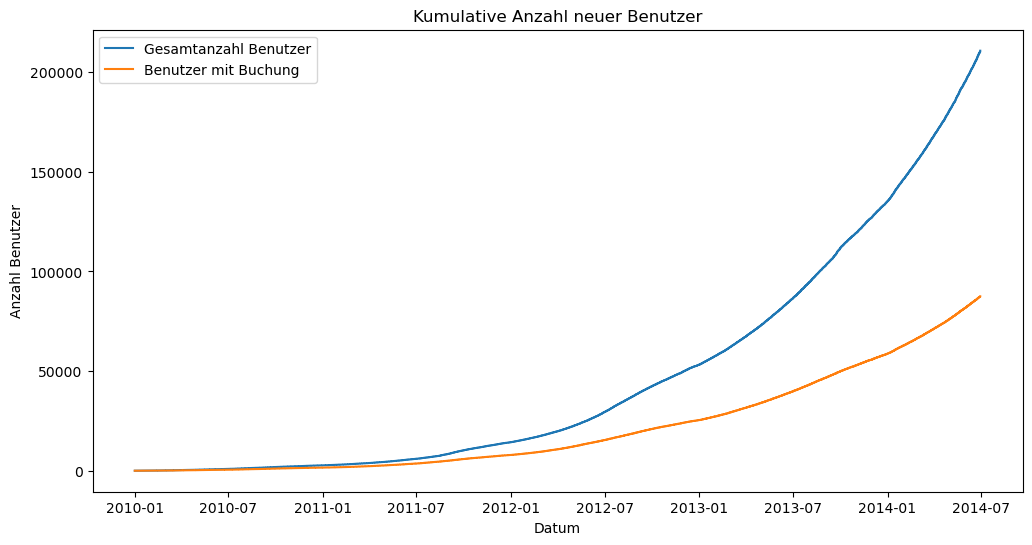

In [8]:
# Kumulative Anzahl neuer Benutzer über die Zeit
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_user['account_created_date'], df_user['total_users_cumulative'], label='Gesamtanzahl Benutzer')
ax.plot(df_user['account_created_date'], df_user['booked_cumulative'], label='Benutzer mit Buchung')
ax.set(
    title='Kumulative Anzahl neuer Benutzer',
    xlabel='Datum',
    ylabel='Anzahl Benutzer'
)
ax.legend()
plt.show()

In [5]:
# Detaiiliertere Statistiken nach Zielort
for destination in df_user['destination_country'].unique():
    if destination != 'NDF':
        df_user[f'booked_{destination}'] = df_user['destination_country'] == destination
        df_user[f'booked_{destination}_cumulative'] = df_user[f'booked_{destination}'].cumsum()

# Separater Zähler für Buchungen außerhalb der USA, da diese häufig sind
df_user['booked_non_US'] = (df_user['destination_country'] != 'US') & (df_user['destination_country'] != 'NDF')
df_user['booked_non_US_cumulative'] = df_user['booked_non_US'].cumsum()

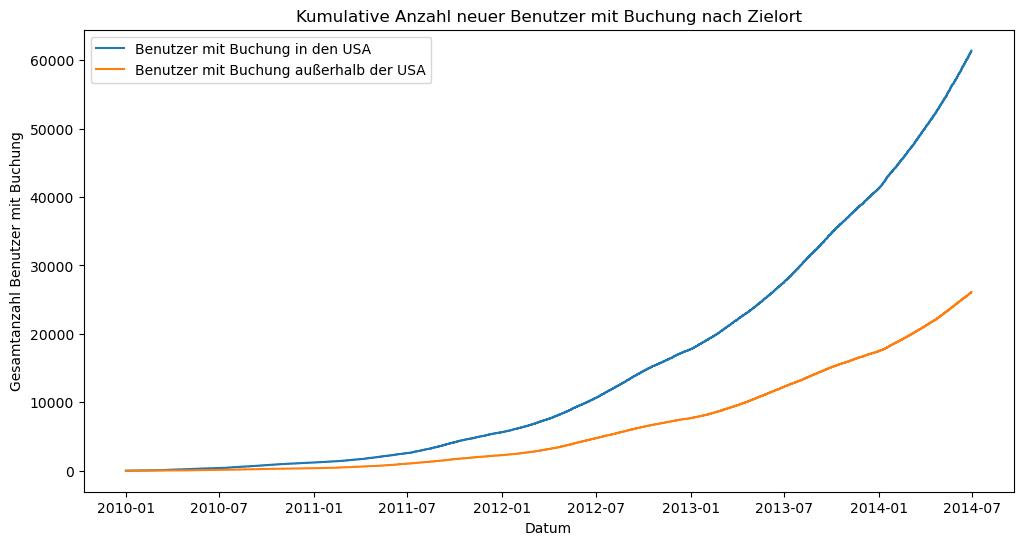

In [10]:
# Visualisierung der kumulativen Buchungen nach Zielort (USA vs. Nicht-USA)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_user['account_created_date'], df_user['booked_US_cumulative'], label='Benutzer mit Buchung in den USA')
ax.plot(df_user['account_created_date'], df_user['booked_non_US_cumulative'], label='Benutzer mit Buchung außerhalb der USA')
ax.set(
    title='Kumulative Anzahl neuer Benutzer mit Buchung nach Zielort',
    xlabel='Datum',
    ylabel='Gesamtanzahl Benutzer mit Buchung'
)
ax.legend()
plt.show()

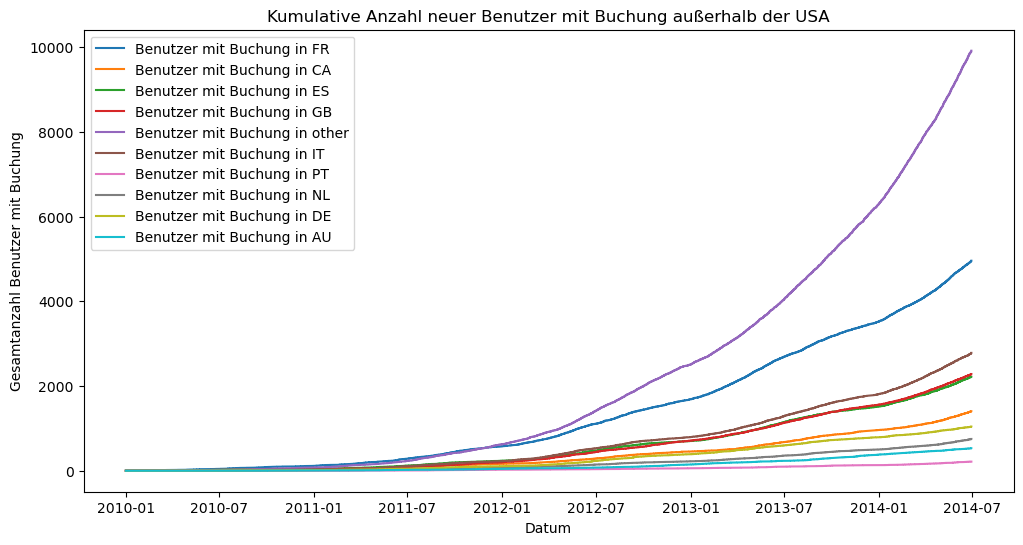

In [11]:
# Visualisierung der kumulativen Buchungen nach Zielort (außerhalb der USA)
fig, ax = plt.subplots(figsize=(12, 6))
for destination in df_user['destination_country'].unique():
    if destination != 'NDF' and destination != 'US':
        ax.plot(df_user['account_created_date'], df_user[f'booked_{destination}_cumulative'], label=f'Benutzer mit Buchung in {destination}')
ax.set(
    title='Kumulative Anzahl neuer Benutzer mit Buchung außerhalb der USA',
    xlabel='Datum',
    ylabel='Gesamtanzahl Benutzer mit Buchung'
)
ax.legend()
plt.show()

## 1.2. Buchungen nach Monat

In [6]:
# Monatliche Zusammenfassung der Benutzer und Buchungen
df_user['month'] = df_user['account_created_date'].dt.to_period('M')
df_monthly_summary = df_user.groupby('month').agg(
    total_users = ('user_id', 'count'),
    booked_users = ('booked', 'sum'),
    booked_US = ('booked_US', 'sum'),
    booked_FR = ('booked_FR', 'sum'),
    booked_DE = ('booked_DE', 'sum'),
    booked_CA = ('booked_CA', 'sum'),
    booked_GB = ('booked_GB', 'sum'),
    booked_AU = ('booked_AU', 'sum'),
    booked_IT = ('booked_IT', 'sum'),
    booked_ES = ('booked_ES', 'sum'),
    booked_NL = ('booked_NL', 'sum'),
    booked_PT = ('booked_PT', 'sum'),
    booked_other = ('booked_other', 'sum'),
    booked_non_US = ('booked_non_US', 'sum'),
).reset_index()
df_monthly_summary['conversion_rate'] = round(df_monthly_summary['booked_users'] / df_monthly_summary['total_users'] * 100, 2)

In [7]:
df_monthly_summary.head()

month  total_users  booked_users  booked_US  booked_FR  booked_DE  \
0  2010-01           61            32         22          5          0   
1  2010-02          102            55         38          7          0   
2  2010-03          162           105         91          7          0   
3  2010-04          154            88         72          5          0   
4  2010-05          220           125         94         13          0   

   booked_CA  booked_GB  booked_AU  booked_IT  booked_ES  booked_NL  \
0          4          0          0          0          1          0   
1          2          3          0          2          1          0   
2          1          0          0          1          1          0   
3          3          1          0          1          5          1   
4          4          1          0          3          5          1   

   booked_PT  booked_other  booked_non_US  conversion_rate  
0          0             0             10            52.46  
1          0             2             17            53.92  
2          1             3             14            64.81  
3          0             0             16            57.14  
4          0             4             31            56.82

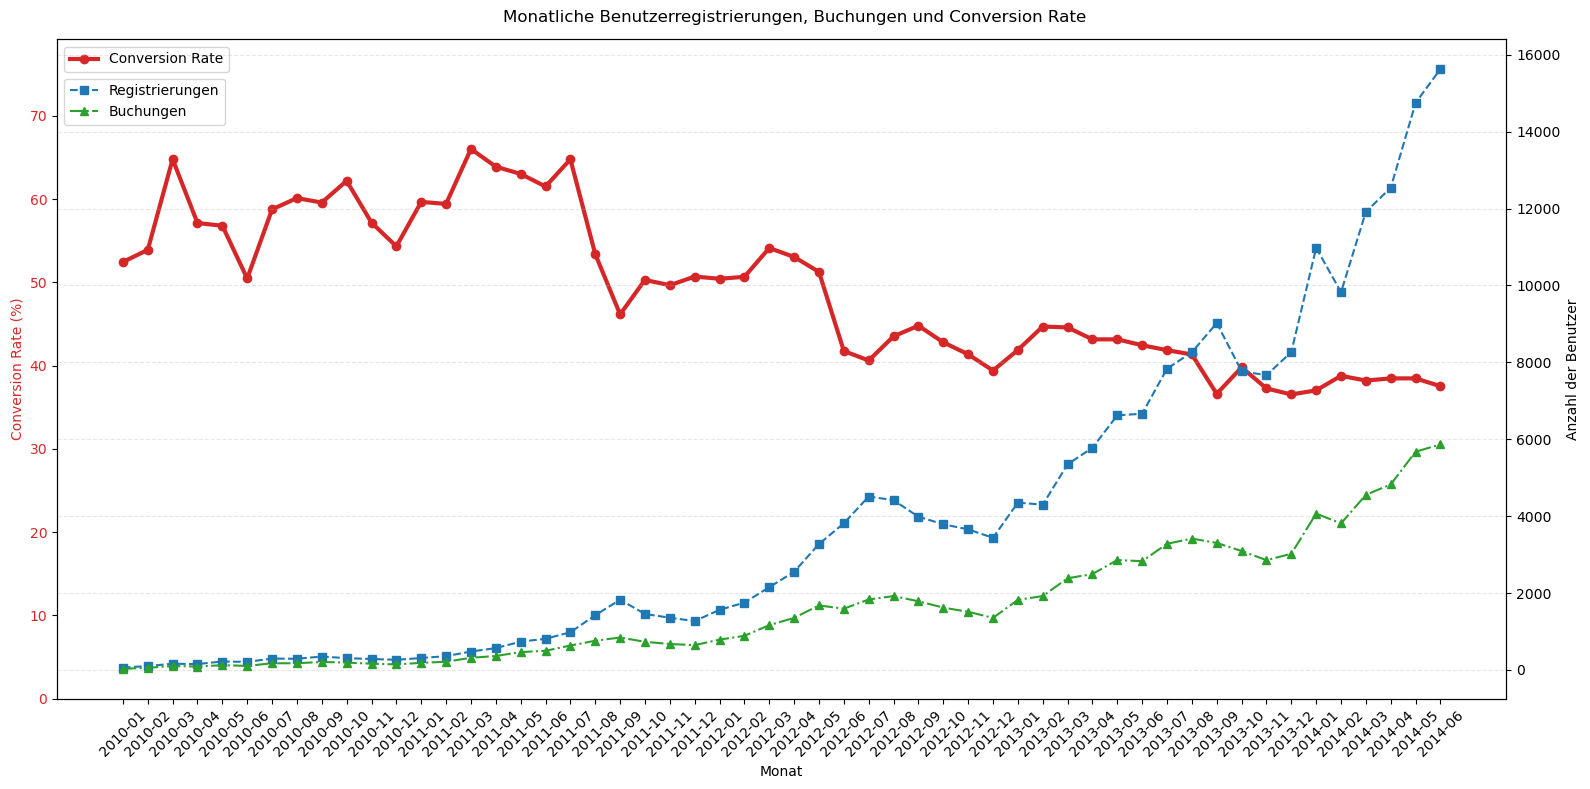

In [7]:
# Visualisierung von Registrierungen, Buchungen und Conversion Rate auf zwei Achsen
fig, ax1 = plt.subplots(figsize=(16, 8))

# X-Achse (Monate) vorbereiten
df_monthly_summary['month_str'] = df_monthly_summary['month'].astype(str)

# Linke Achse: Conversion Rate
color_cv = 'tab:red'
ax1.set_xlabel('Monat')
ax1.set_ylabel('Conversion Rate (%)', color=color_cv)
ln1 = ax1.plot(df_monthly_summary['month_str'], df_monthly_summary['conversion_rate'], 
               color=color_cv, marker='o', linewidth=3, label='Conversion Rate')
ax1.tick_params(axis='y', labelcolor=color_cv)
ax1.set_ylim(0, df_monthly_summary['conversion_rate'].max() * 1.2)

# Rechte Achse: Anzahl Benutzer
ax2 = ax1.twinx()
color_reg = 'tab:blue'
color_book = 'tab:green'
ax2.set_ylabel('Anzahl der Benutzer', color='black')
ln2 = ax2.plot(df_monthly_summary['month_str'], df_monthly_summary['total_users'], 
               color=color_reg, linestyle='--', marker='s', label='Registrierungen')
ln3 = ax2.plot(df_monthly_summary['month_str'], df_monthly_summary['booked_users'], 
               color=color_book, linestyle='-.', marker='^', label='Buchungen')
ax2.tick_params(axis='y', labelcolor='black')

# Legende erstellen
ax1.legend(loc=(0.005,0.95))
ax2.legend(loc=(0.005,0.87))

fig.suptitle('Monatliche Benutzerregistrierungen, Buchungen und Conversion Rate')

# X-Achse Formatierung verbessern
ax1.tick_params(axis='x', rotation=45, labelsize=10)

# Gitterlinien hinzufügen
ax2.grid(axis='y', linestyle='--', alpha=0.3)
fig.tight_layout()
plt.show()

In [8]:
# Zusätzliche prozentuale Spalten für Buchungen nach Zielort
for destination in df_user['destination_country'].unique():
    if destination != 'NDF' and destination != 'US':
        df_monthly_summary[f'booked_{destination}_percent'] = df_monthly_summary[f'booked_{destination}'] / df_monthly_summary['booked_non_US']

/var/folders/3n/g7xqvy950q70jssr4zklpf8m0000gn/T/ipykernel_11897/3360875954.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


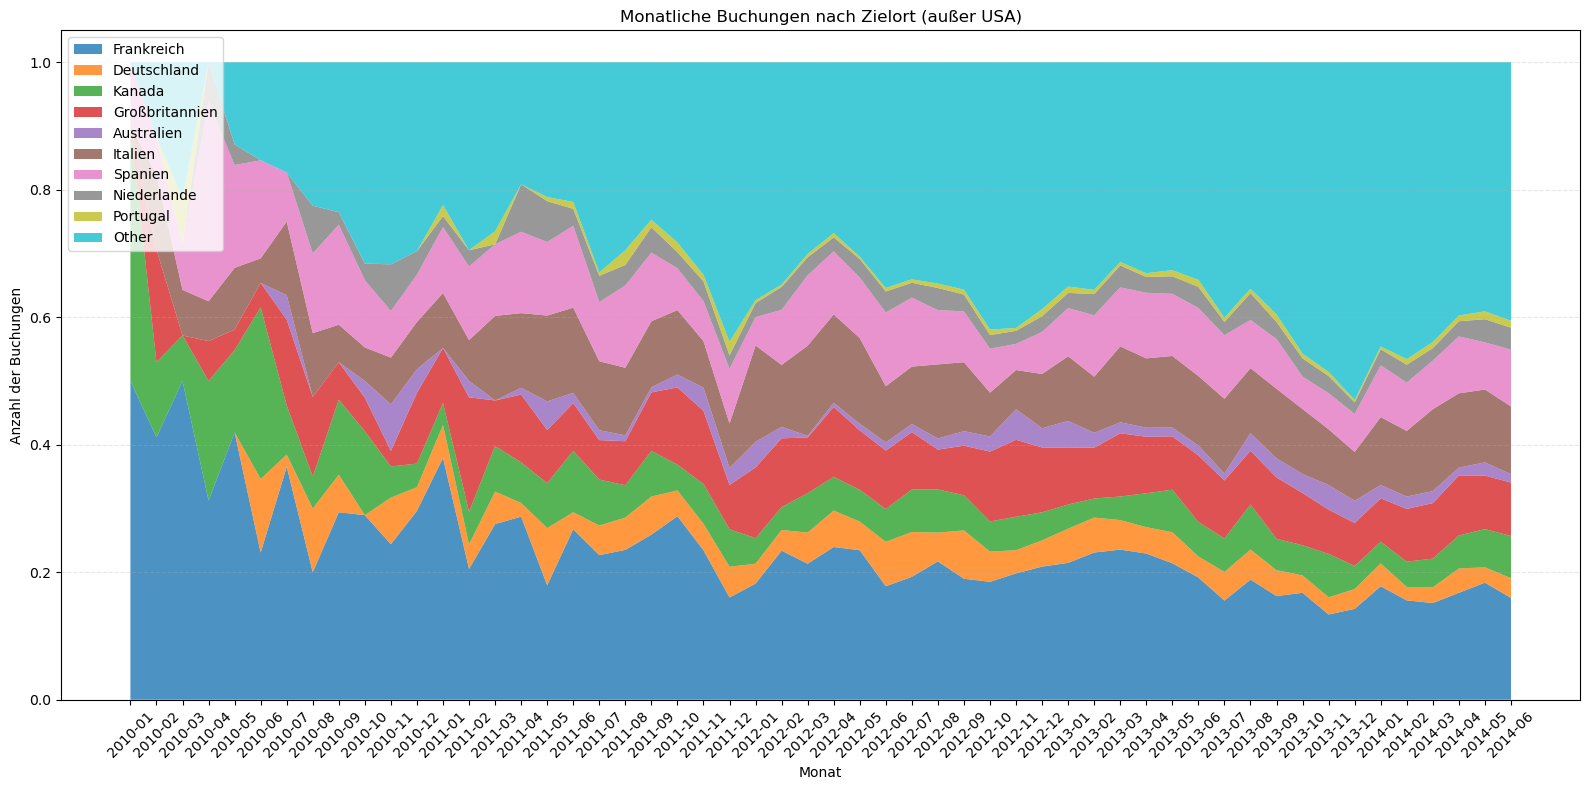

In [10]:
# Visualisierung der monatlichen Buchungen nach Zielort (außer USA) als Flächendiagramm
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(df_monthly_summary['month_str'],
             df_monthly_summary['booked_FR_percent'],
             df_monthly_summary['booked_DE_percent'],
             df_monthly_summary['booked_CA_percent'],
             df_monthly_summary['booked_GB_percent'],
             df_monthly_summary['booked_AU_percent'],
             df_monthly_summary['booked_IT_percent'],
             df_monthly_summary['booked_ES_percent'],
             df_monthly_summary['booked_NL_percent'],
             df_monthly_summary['booked_PT_percent'],
             df_monthly_summary['booked_other_percent'],
             labels=['Frankreich', 'Deutschland', 'Kanada', 'Großbritannien', 
                     'Australien', 'Italien', 'Spanien', 'Niederlande', 'Portugal', 'Other'],
             alpha=0.8)

ax.set(
    title='Monatliche Buchungen nach Zielort (außer USA)',
    xlabel='Monat',
    ylabel='Anzahl der Buchungen'
)

ax.legend(loc='upper left')
ax.tick_params(axis='x', rotation=45, labelsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.3)
fig.tight_layout()
fig.show()

# 2. Conversion Rate und Korrelationen

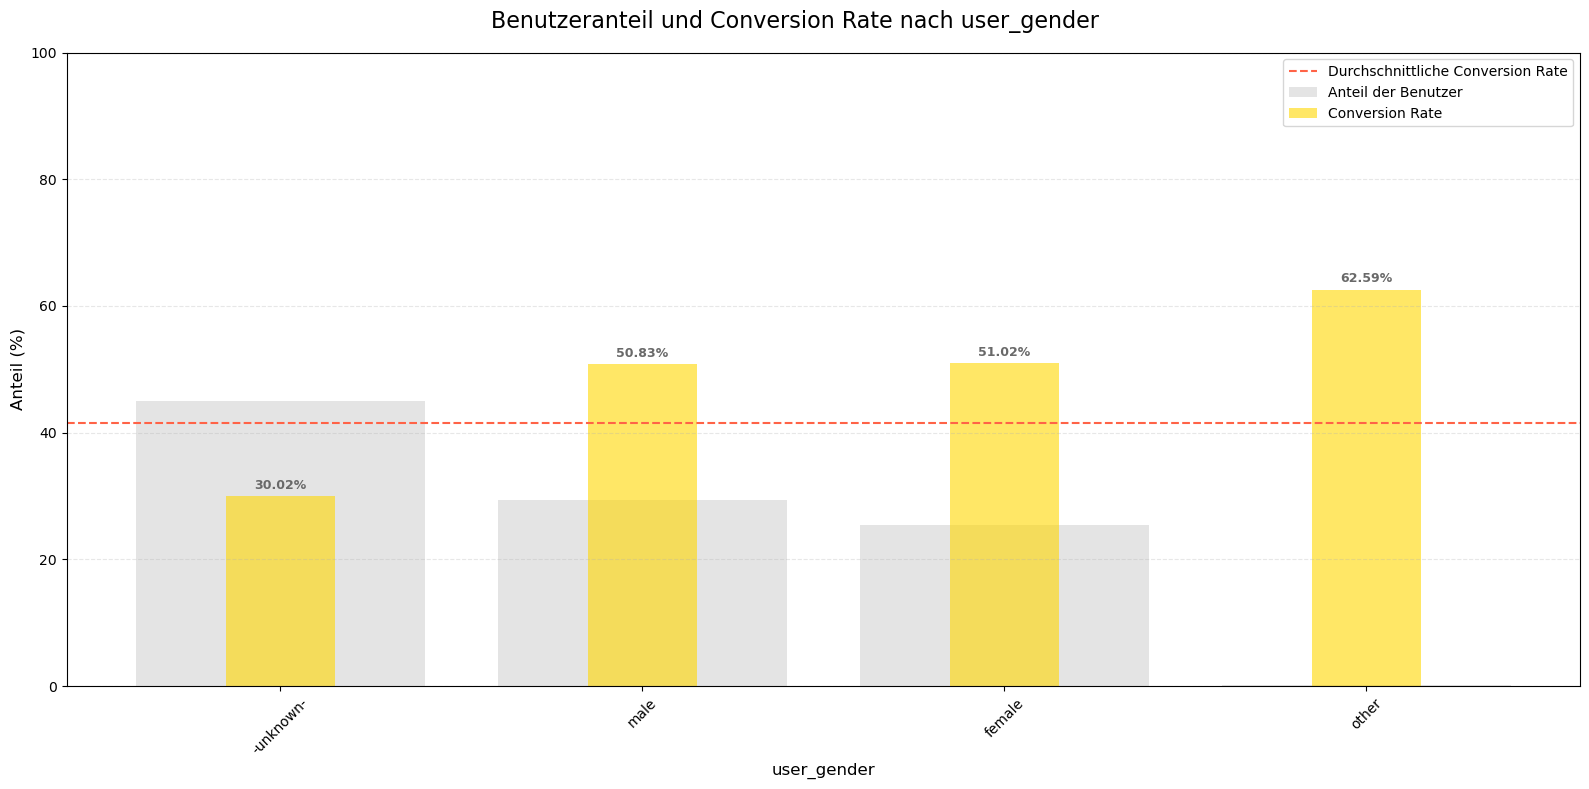

/Users/daniel/Desktop/dscb310-projekt/functions.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_summary = df.groupby(column_name).agg(


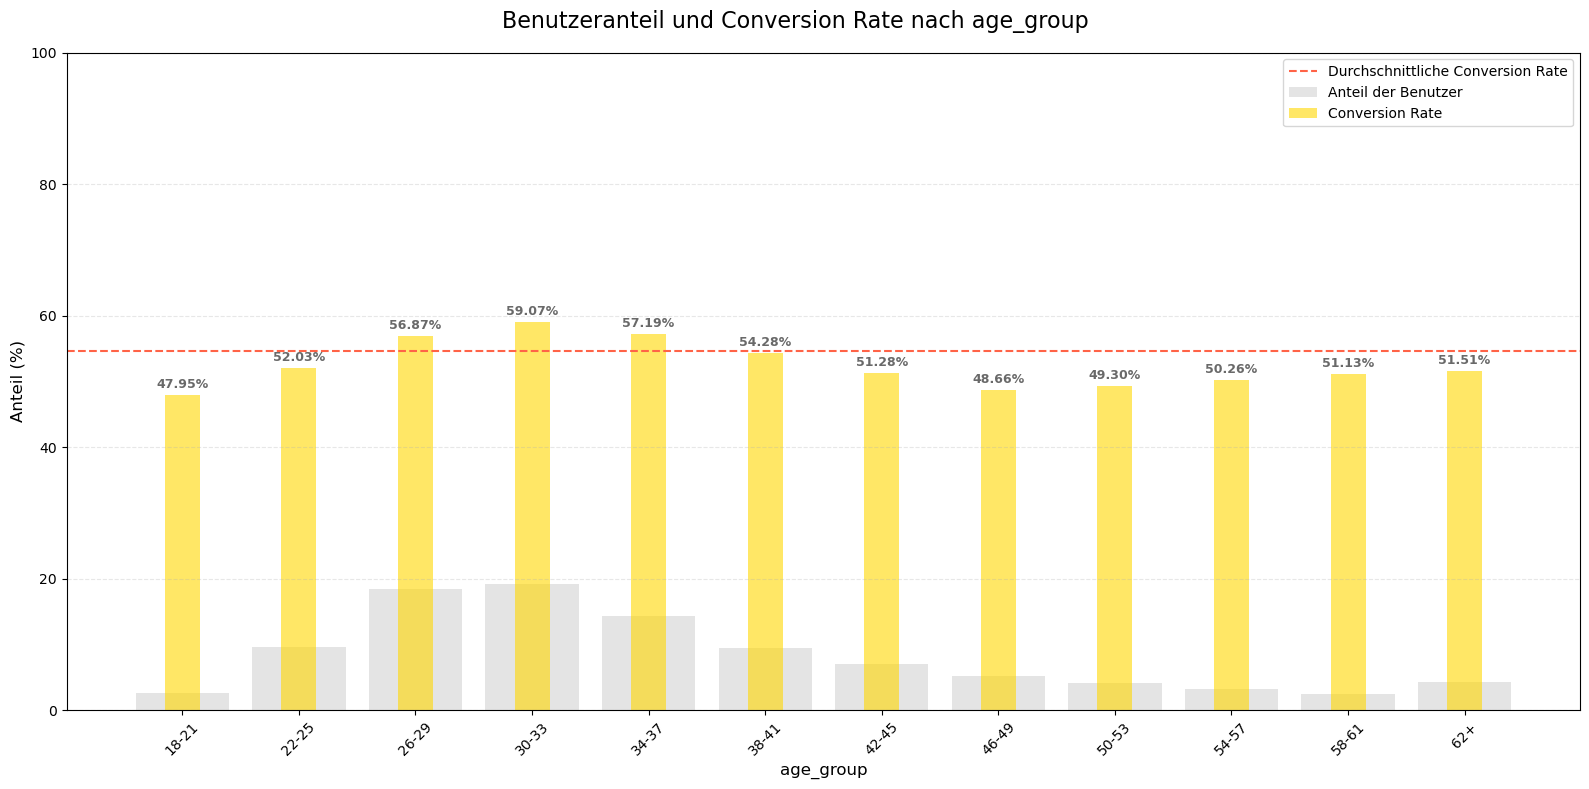

In [9]:
f.plot_share_vs_conversion(df_user, 'user_gender')

bins = list(range(18, 63, 4)) + [float('inf')]
labels = [f'{i}-{i+3}' for i in range (18, 62, 4)] + ['62+']

df_user['age_group'] = pd.cut(df_user['user_age'], bins=bins, labels=labels, right=False)

f.plot_share_vs_conversion(df_user, 'age_group', sortby=['age_group', True])

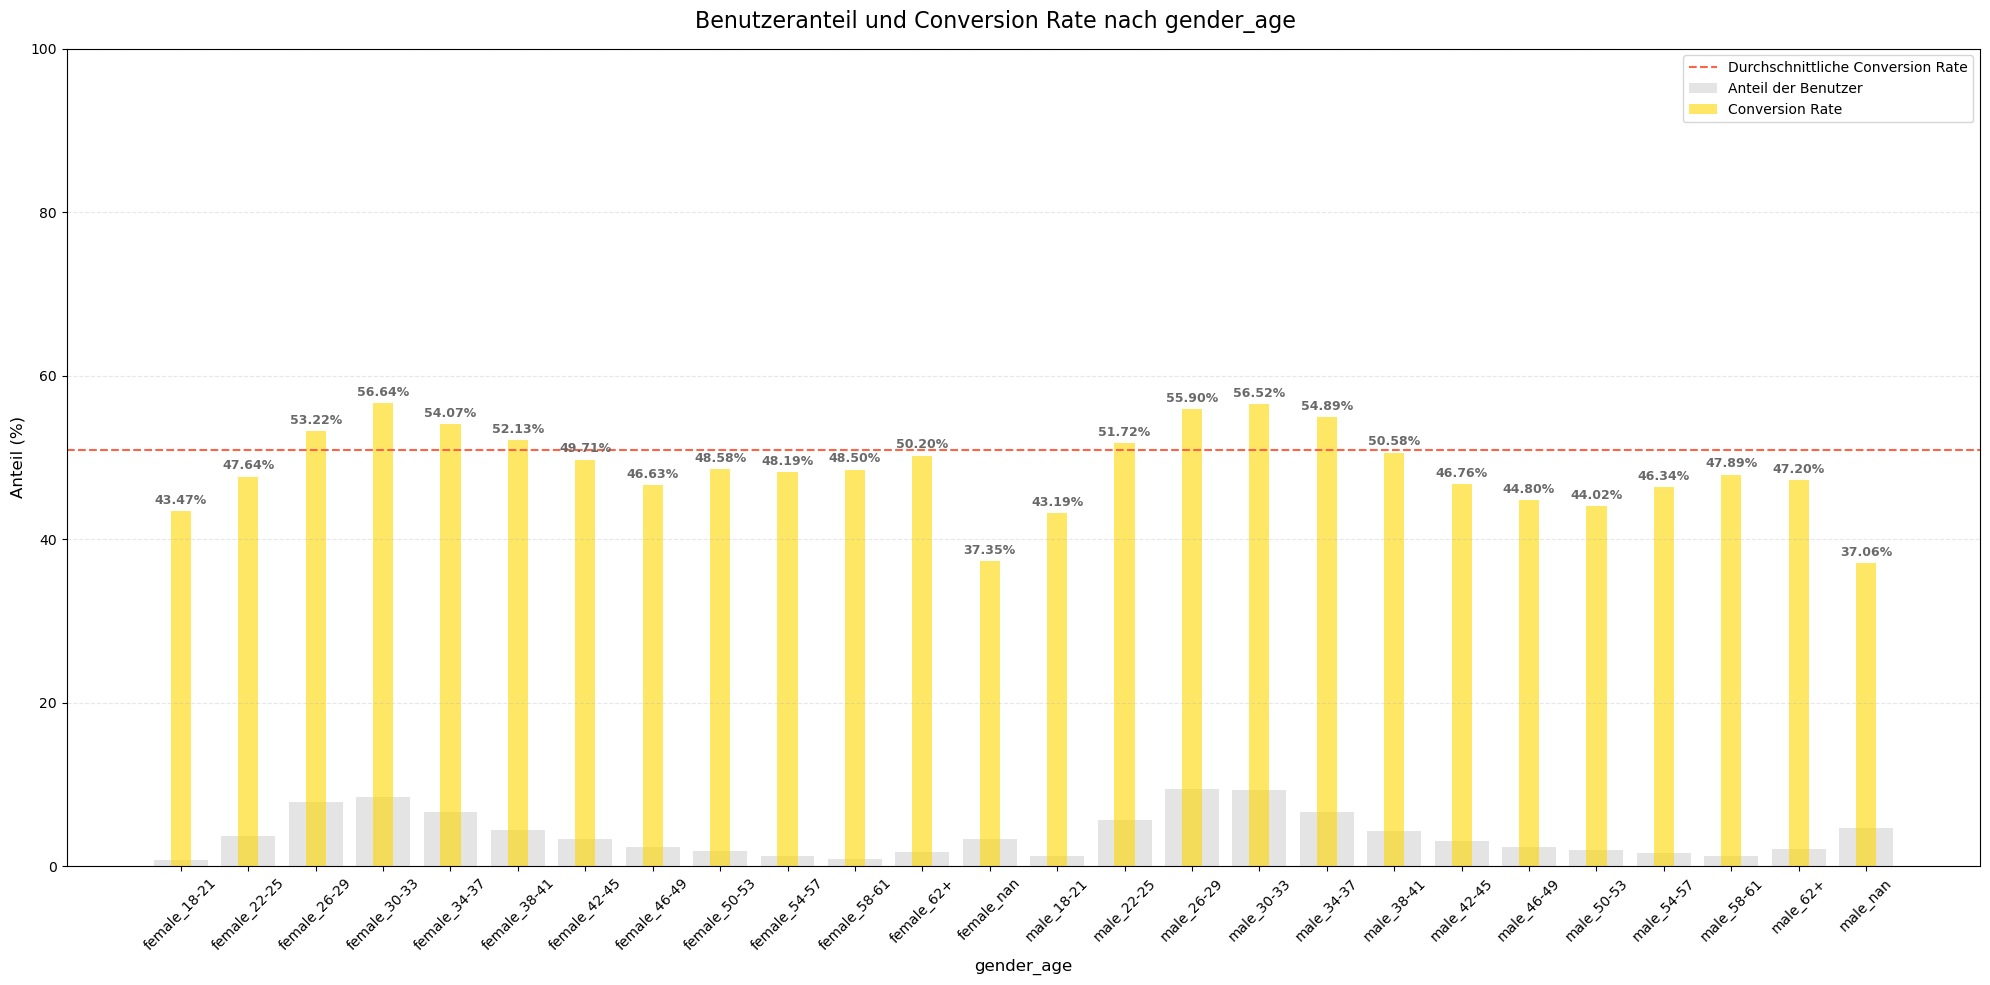

In [10]:
# Erstellung einer kombinierten Spalte aus Geschlecht und Altersgruppe (nur male/female)
df_user['gender_age'] = np.where(
    df_user['user_gender'].isin(['male', 'female']),
    df_user['user_gender'].astype(str) + '_' + df_user['age_group'].astype(str),
    np.nan
)

# Visualisierung der neuen kombinierten Spalte
f.plot_share_vs_conversion(df_user, 'gender_age', size=(20, 10), sortby=['gender_age', True])

Korrelationsanalyse: age_group vs destination_country

1. Datenüberblick:
   age_group: 12 eindeutige Werte
   destination_country: 12 eindeutige Werte
   Gesamtbeobachtungen: 210721

2. Pearsons Chi-Quadrat-Test:
   χ² = 1160.41
   p-Wert = 0.000
   Freiheitsgrade = 121

3. Interpretation:
   Sehr hohe Signifikanz nachgewiesen (p < 0.01)

4. Visualisierung:


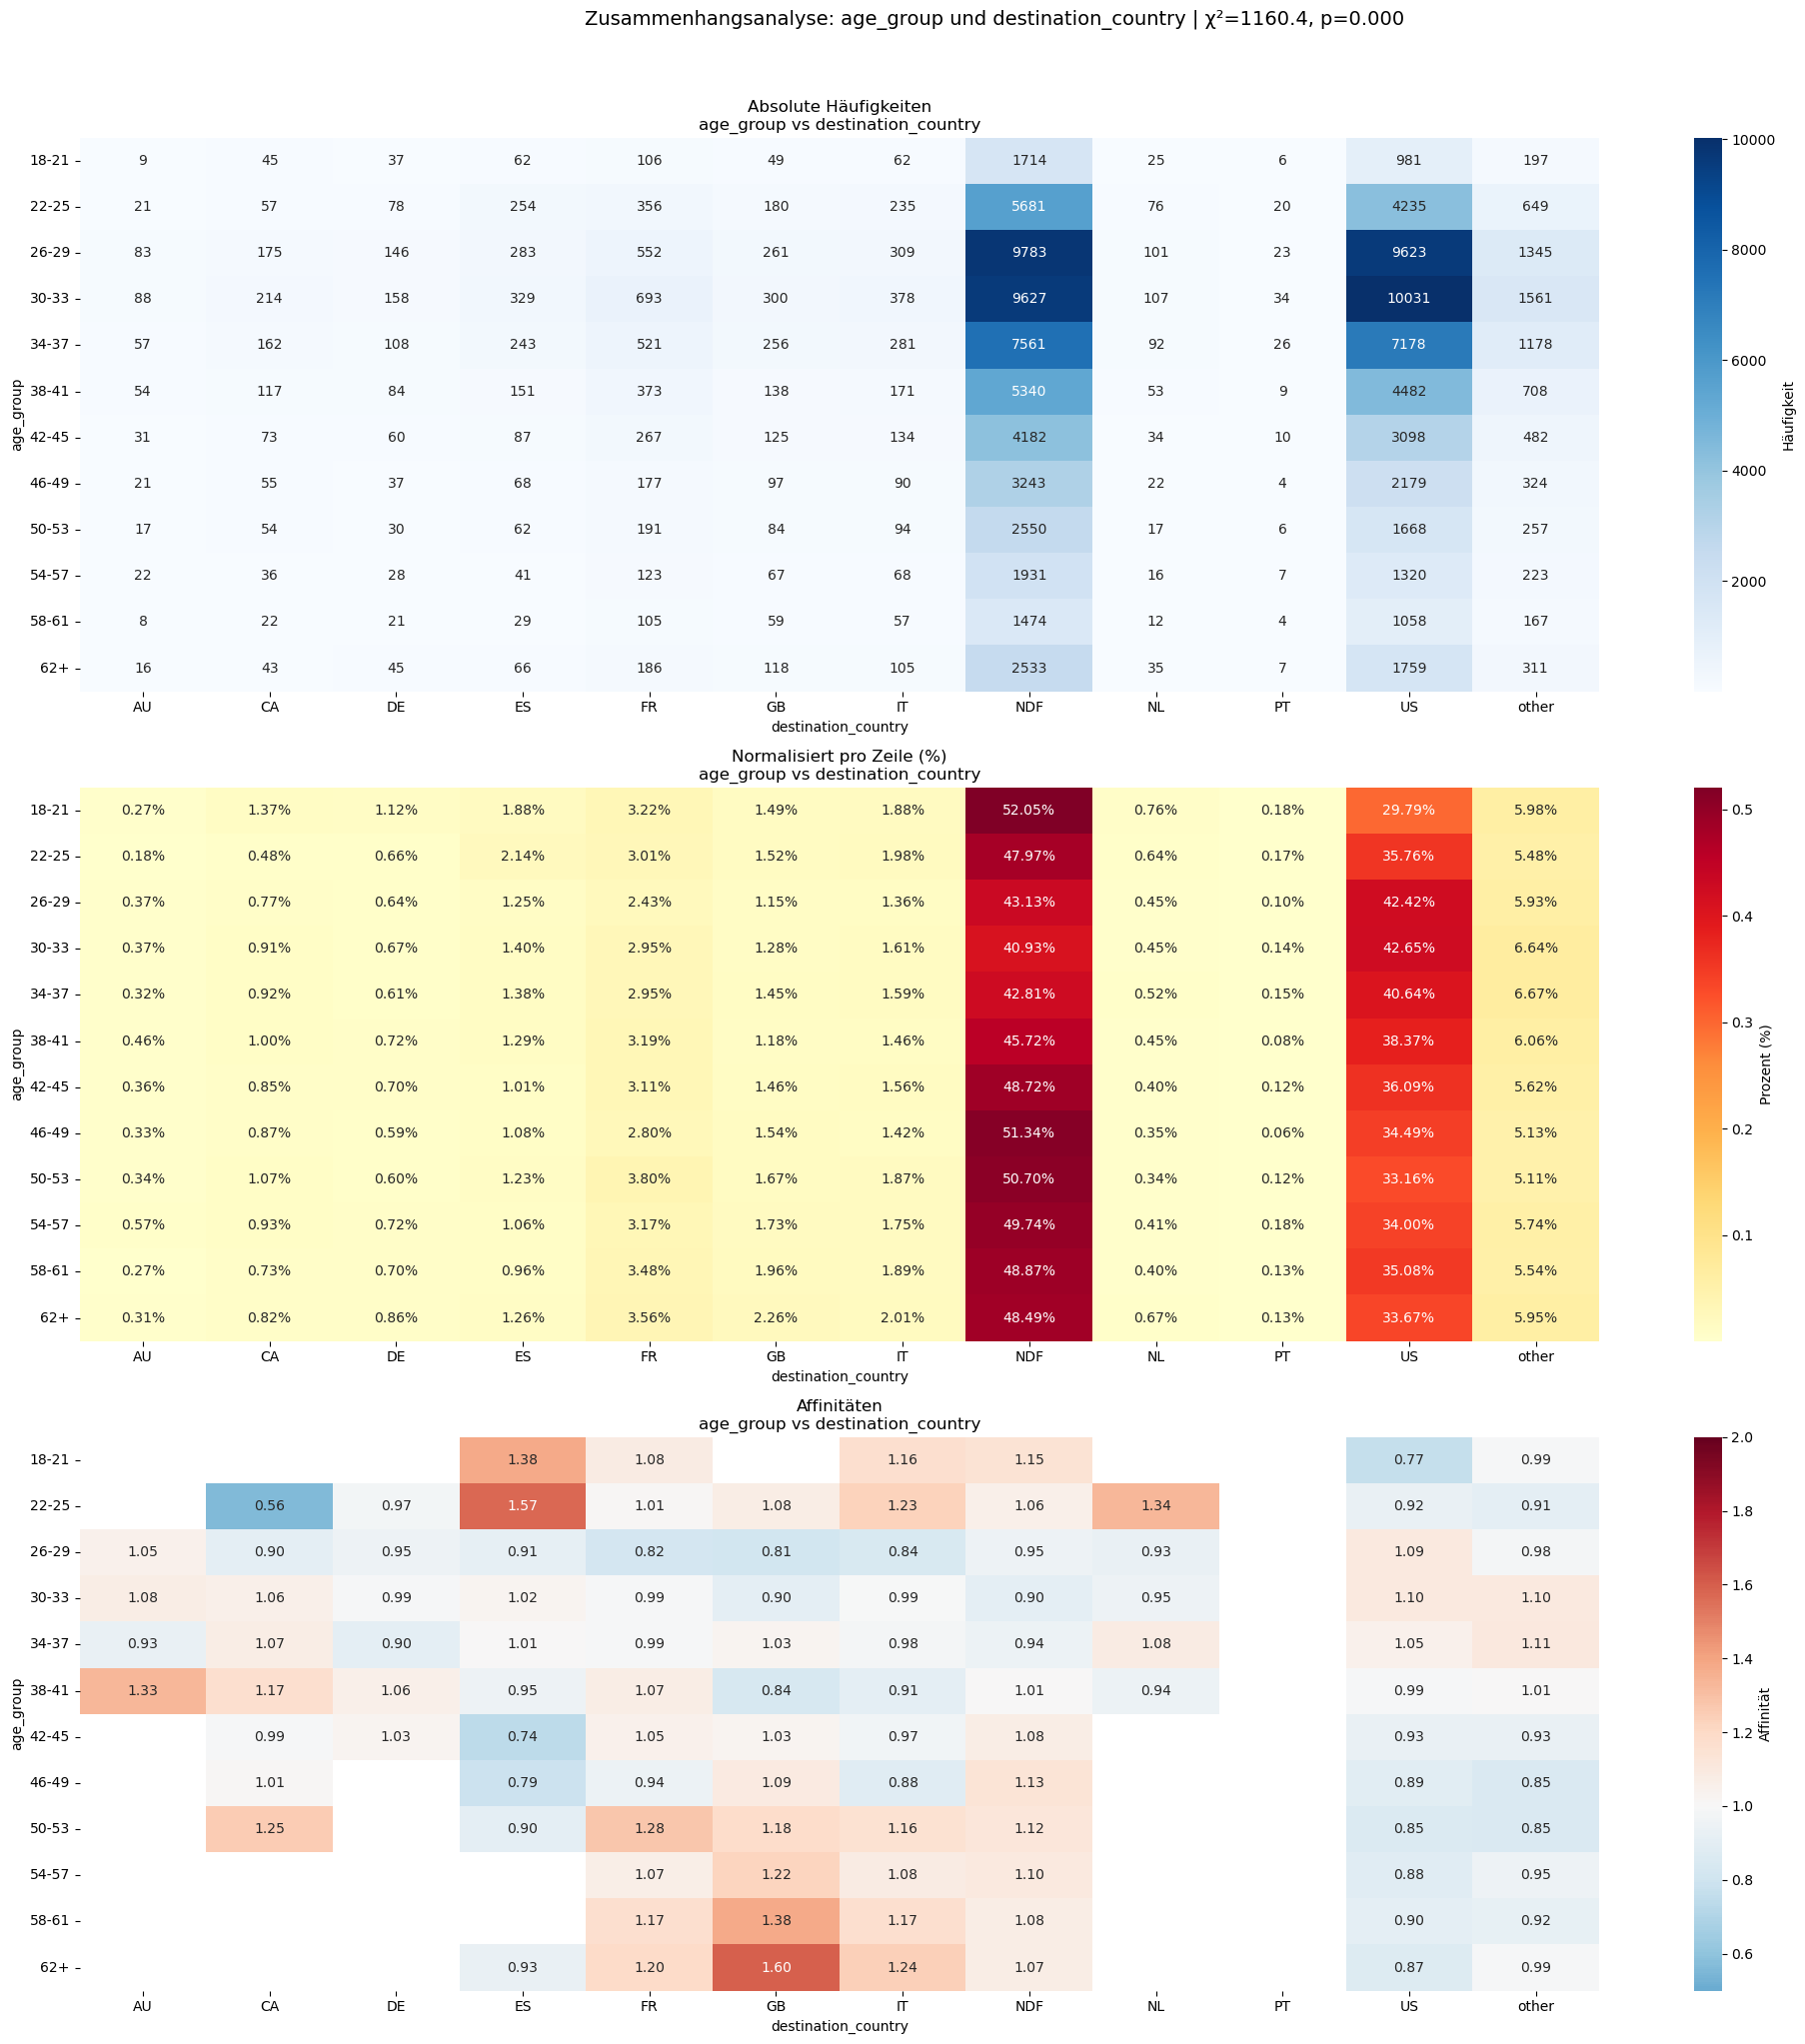


5. Stärkste Assoziationen:
    18-21: NDF (52.05%)
    22-25: NDF (47.97%)
    26-29: NDF (43.13%)
    30-33: US (42.65%)
    34-37: NDF (42.81%)
    38-41: NDF (45.72%)
    42-45: NDF (48.72%)
    46-49: NDF (51.34%)
    50-53: NDF (50.70%)
    54-57: NDF (49.74%)
    58-61: NDF (48.87%)
    62+: NDF (48.49%)



In [11]:
f.categorical_correlation_analysis(df_user, 'age_group', 'destination_country', min_sample=50)

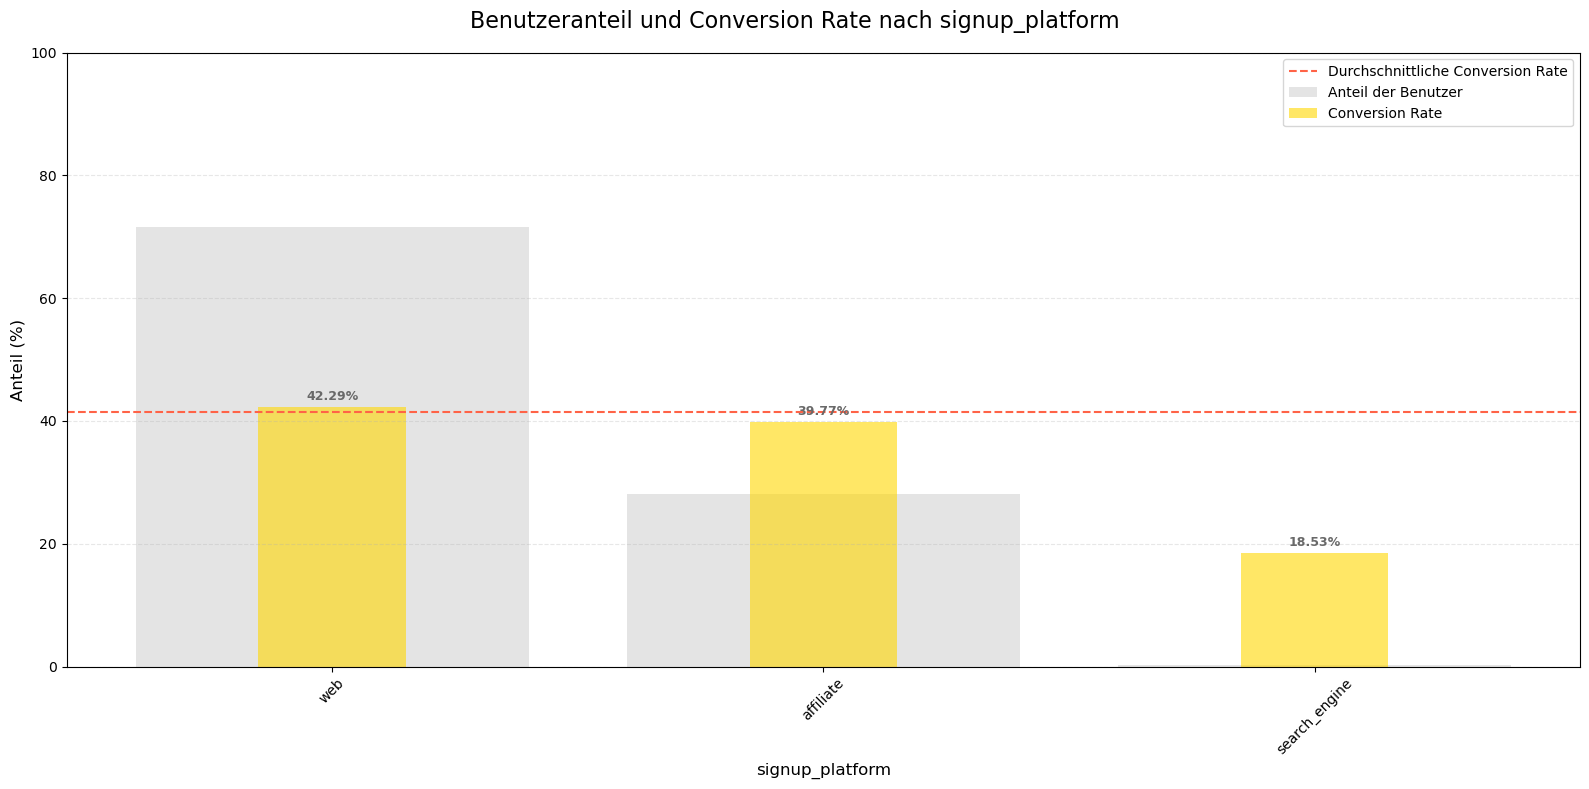

Korrelationsanalyse: signup_platform vs destination_country

1. Datenüberblick:
   signup_platform: 3 eindeutige Werte
   destination_country: 12 eindeutige Werte
   Gesamtbeobachtungen: 210721

2. Pearsons Chi-Quadrat-Test:
   χ² = 281.43
   p-Wert = 0.000
   Freiheitsgrade = 22

3. Interpretation:
   Sehr hohe Signifikanz nachgewiesen (p < 0.01)

4. Visualisierung:


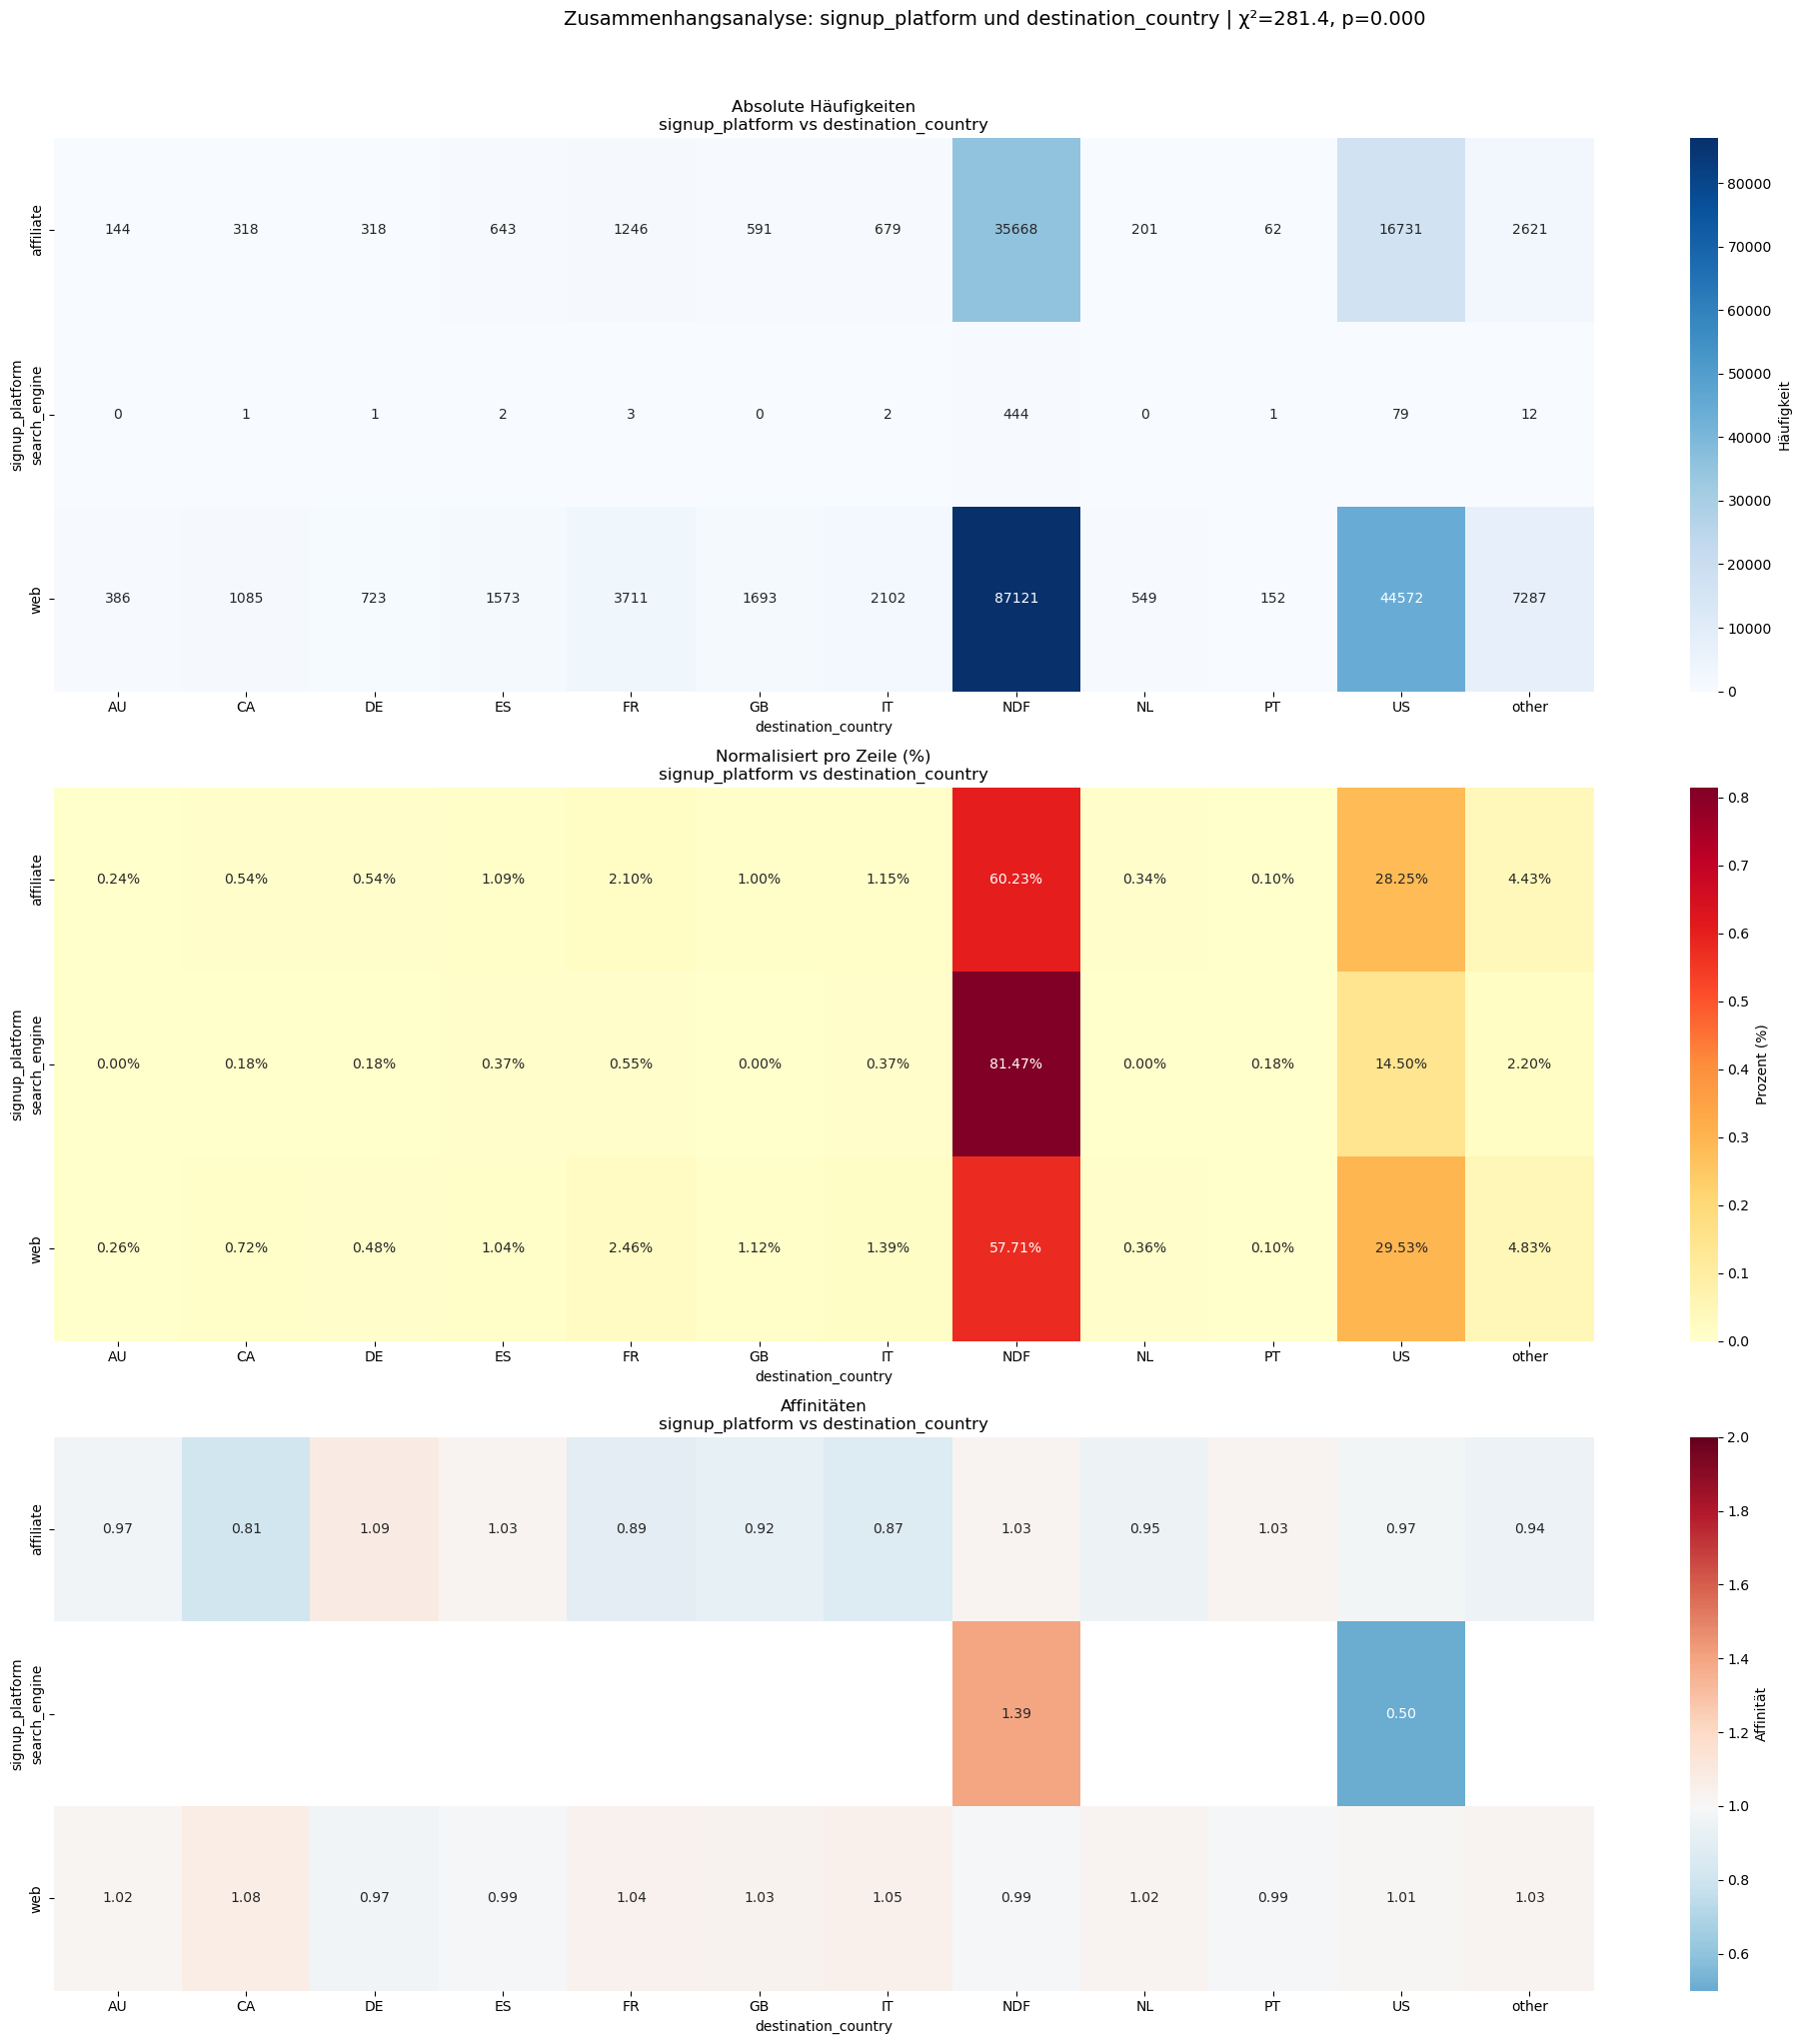


5. Stärkste Assoziationen:
    affiliate: NDF (60.23%)
    search_engine: NDF (81.47%)
    web: NDF (57.71%)

------------------------------------------------------------------------------------------------------------------------------------------------------


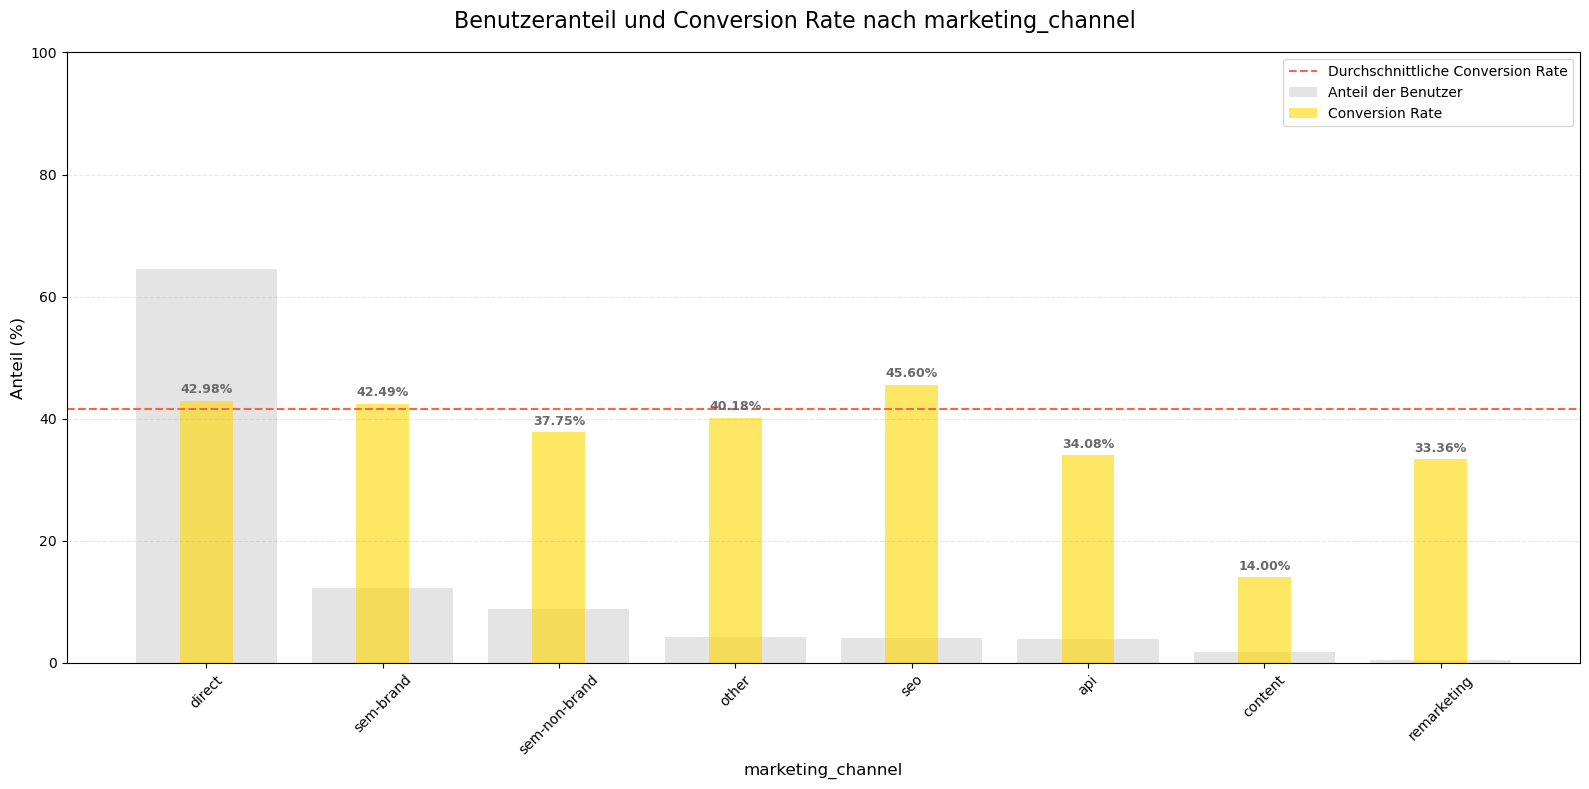

Korrelationsanalyse: marketing_channel vs destination_country

1. Datenüberblick:
   marketing_channel: 8 eindeutige Werte
   destination_country: 12 eindeutige Werte
   Gesamtbeobachtungen: 210721

2. Pearsons Chi-Quadrat-Test:
   χ² = 2370.37
   p-Wert = 0.000
   Freiheitsgrade = 77

3. Interpretation:
   Sehr hohe Signifikanz nachgewiesen (p < 0.01)

4. Visualisierung:


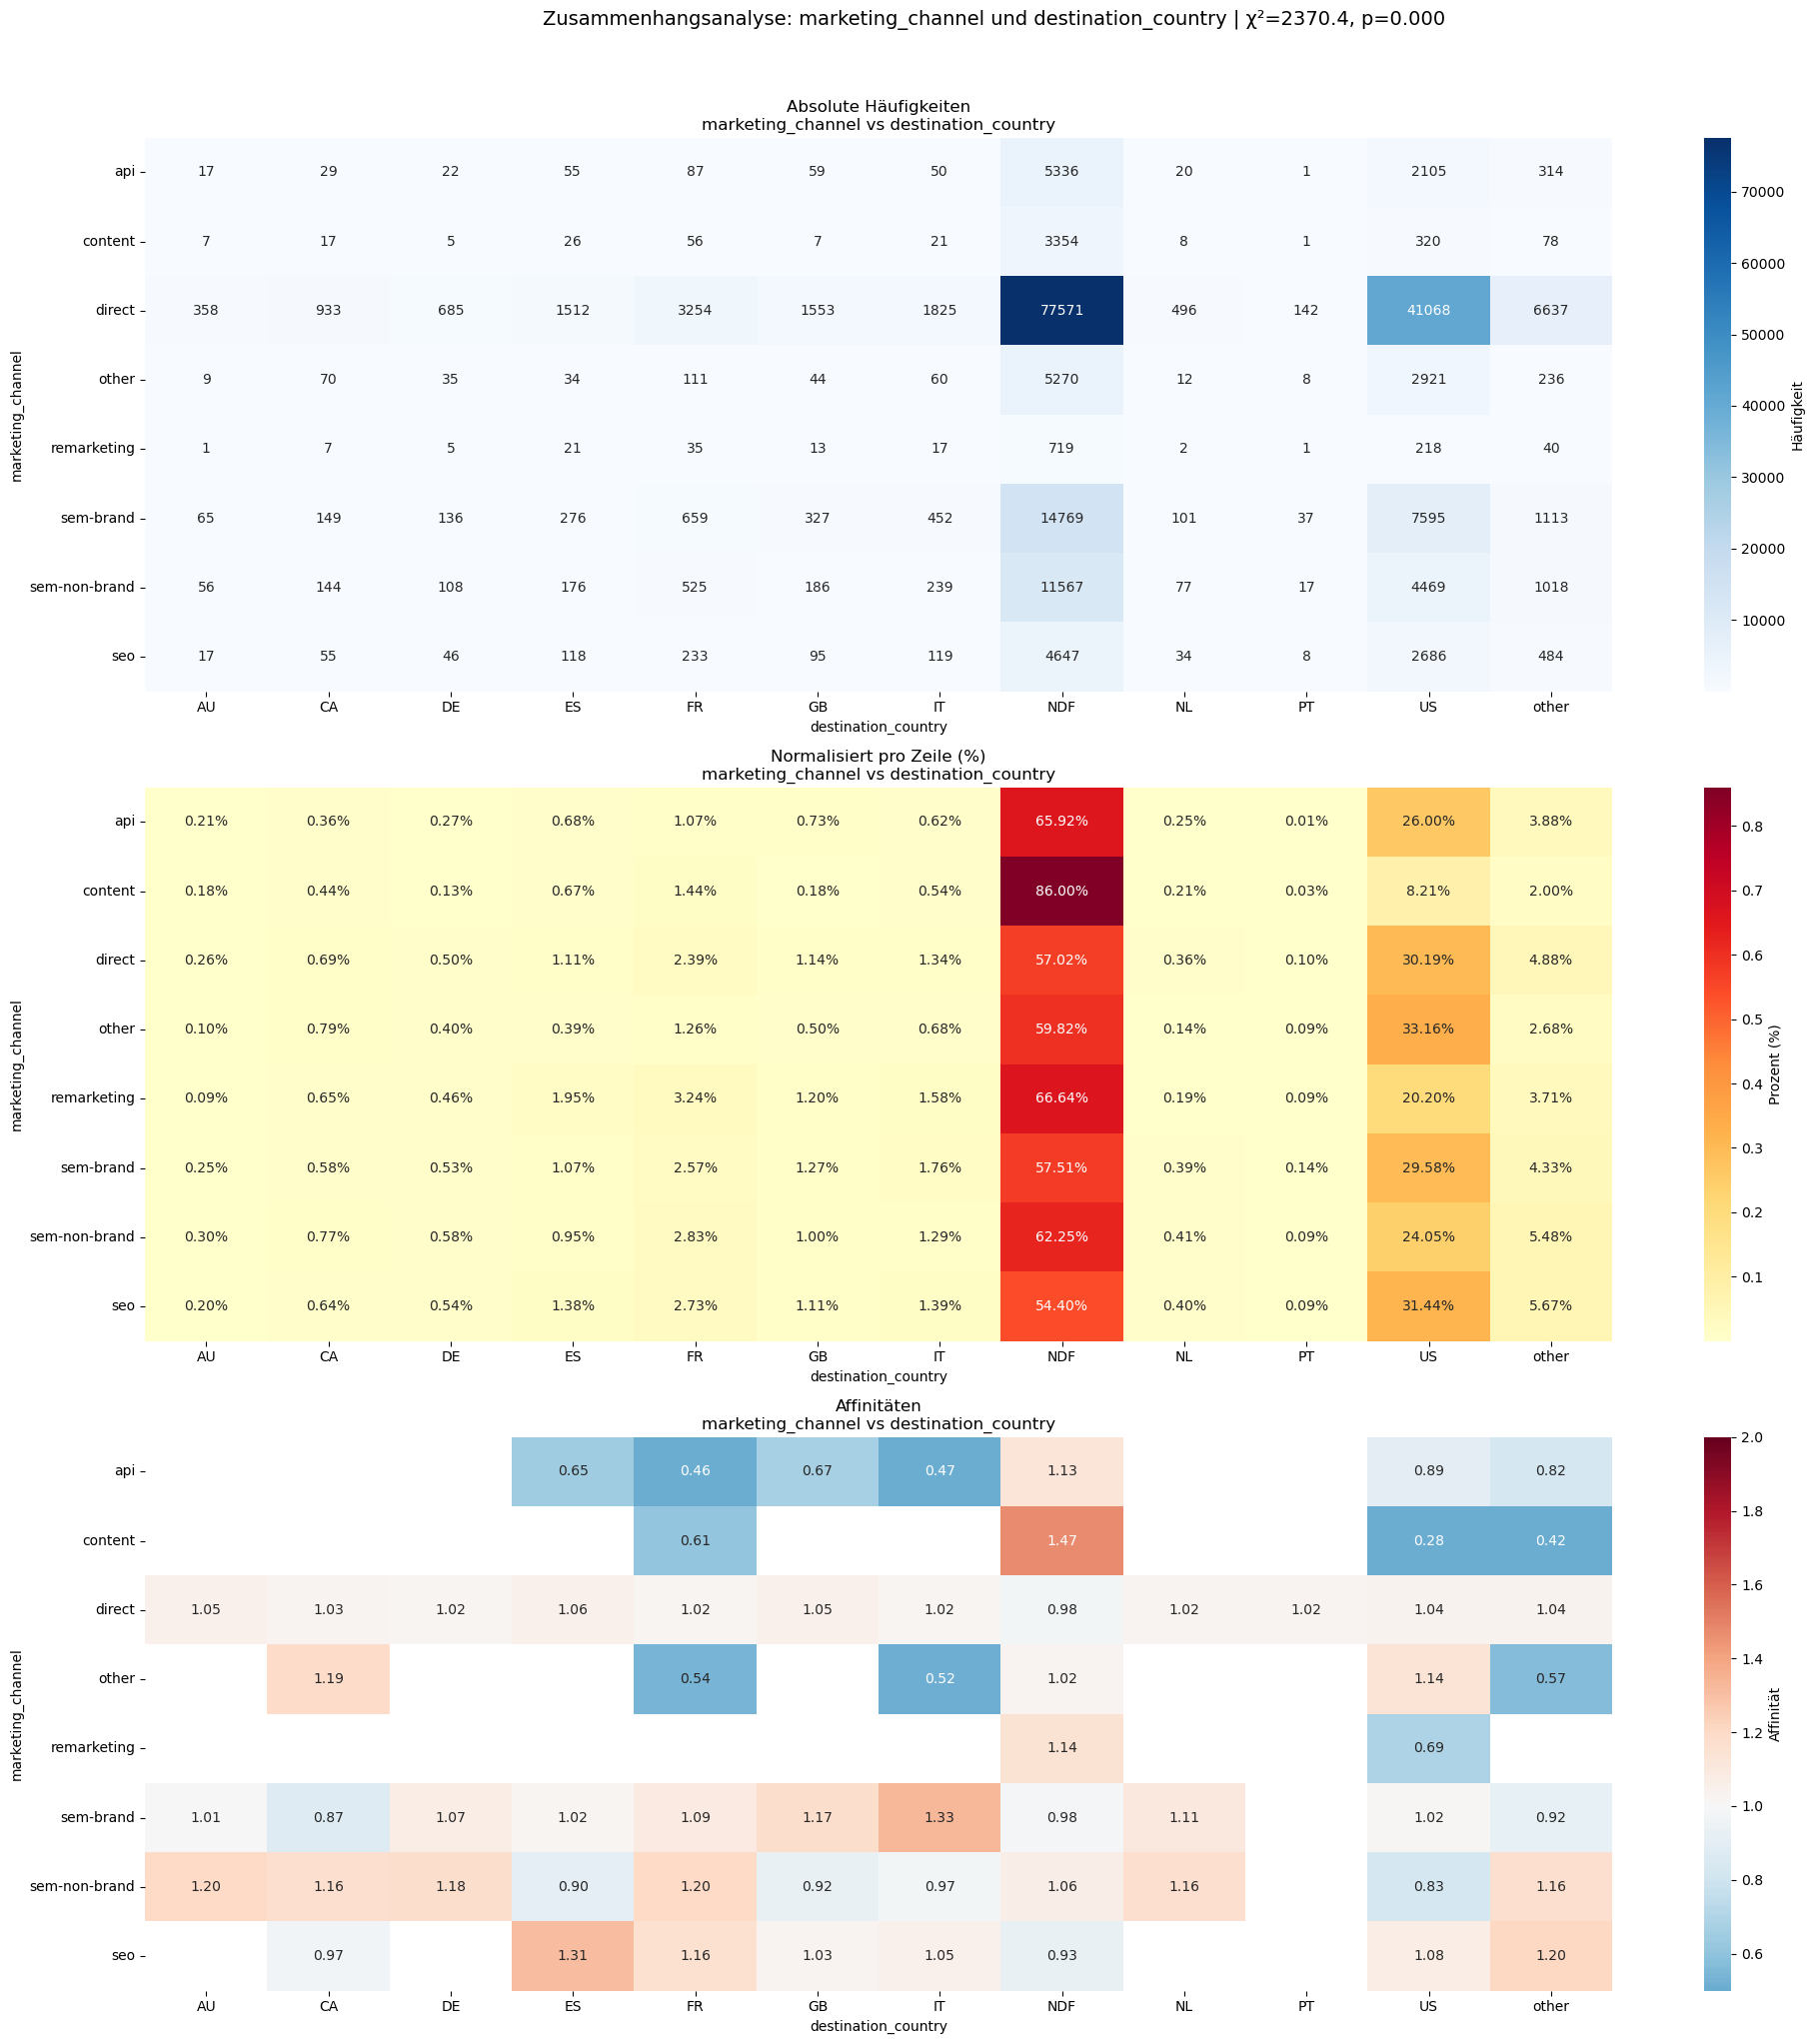


5. Stärkste Assoziationen:
    api: NDF (65.92%)
    content: NDF (86.00%)
    direct: NDF (57.02%)
    other: NDF (59.82%)
    remarketing: NDF (66.64%)
    sem-brand: NDF (57.51%)
    sem-non-brand: NDF (62.25%)
    seo: NDF (54.40%)

------------------------------------------------------------------------------------------------------------------------------------------------------


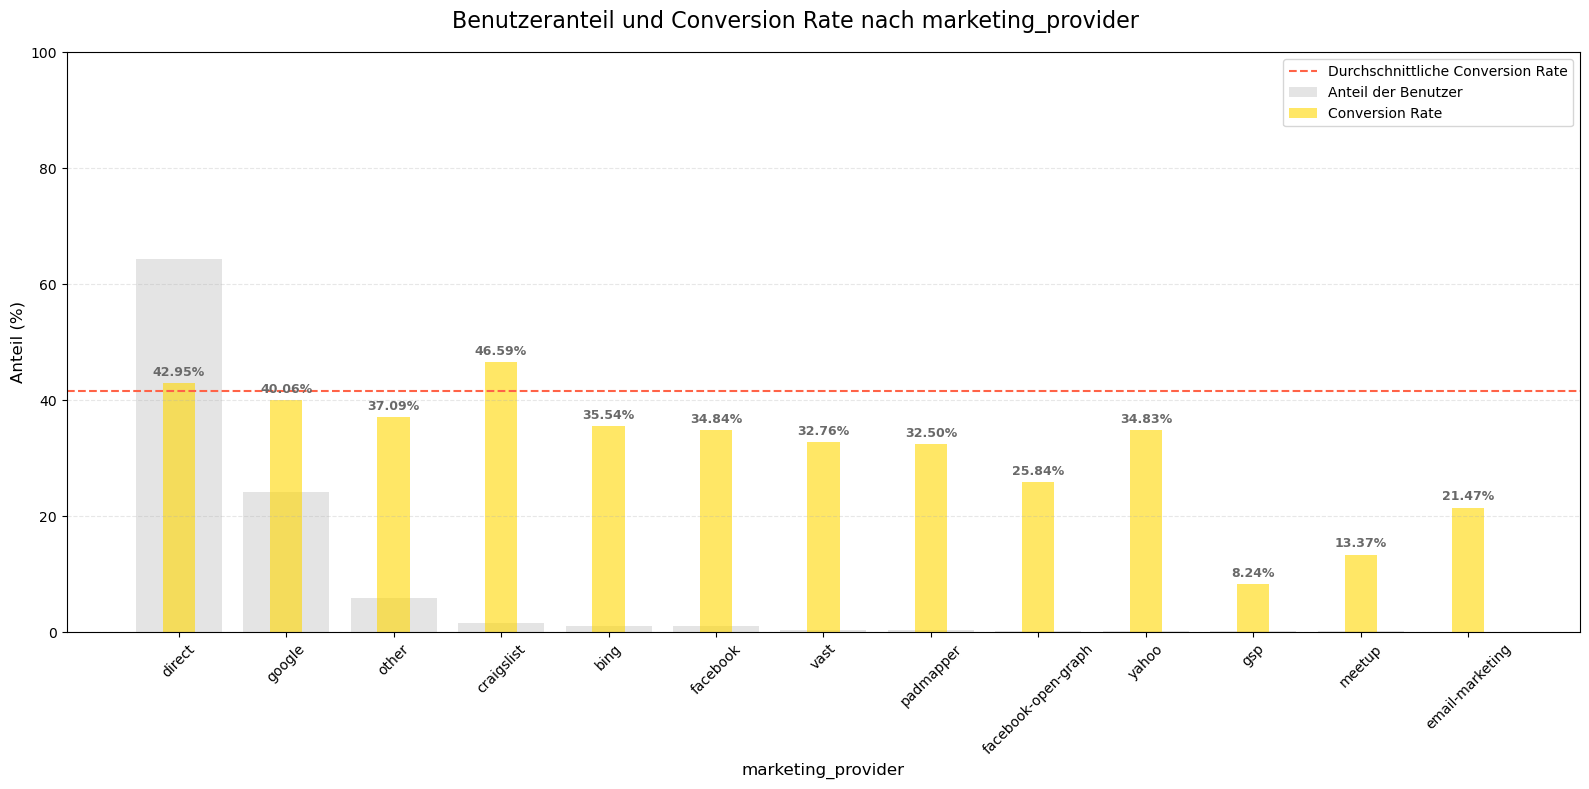

Korrelationsanalyse: marketing_provider vs destination_country

1. Datenüberblick:
   marketing_provider: 13 eindeutige Werte
   destination_country: 12 eindeutige Werte
   Gesamtbeobachtungen: 210721

2. Pearsons Chi-Quadrat-Test:
   χ² = 1425.98
   p-Wert = 0.000
   Freiheitsgrade = 132

3. Interpretation:
   Sehr hohe Signifikanz nachgewiesen (p < 0.01)

4. Visualisierung:


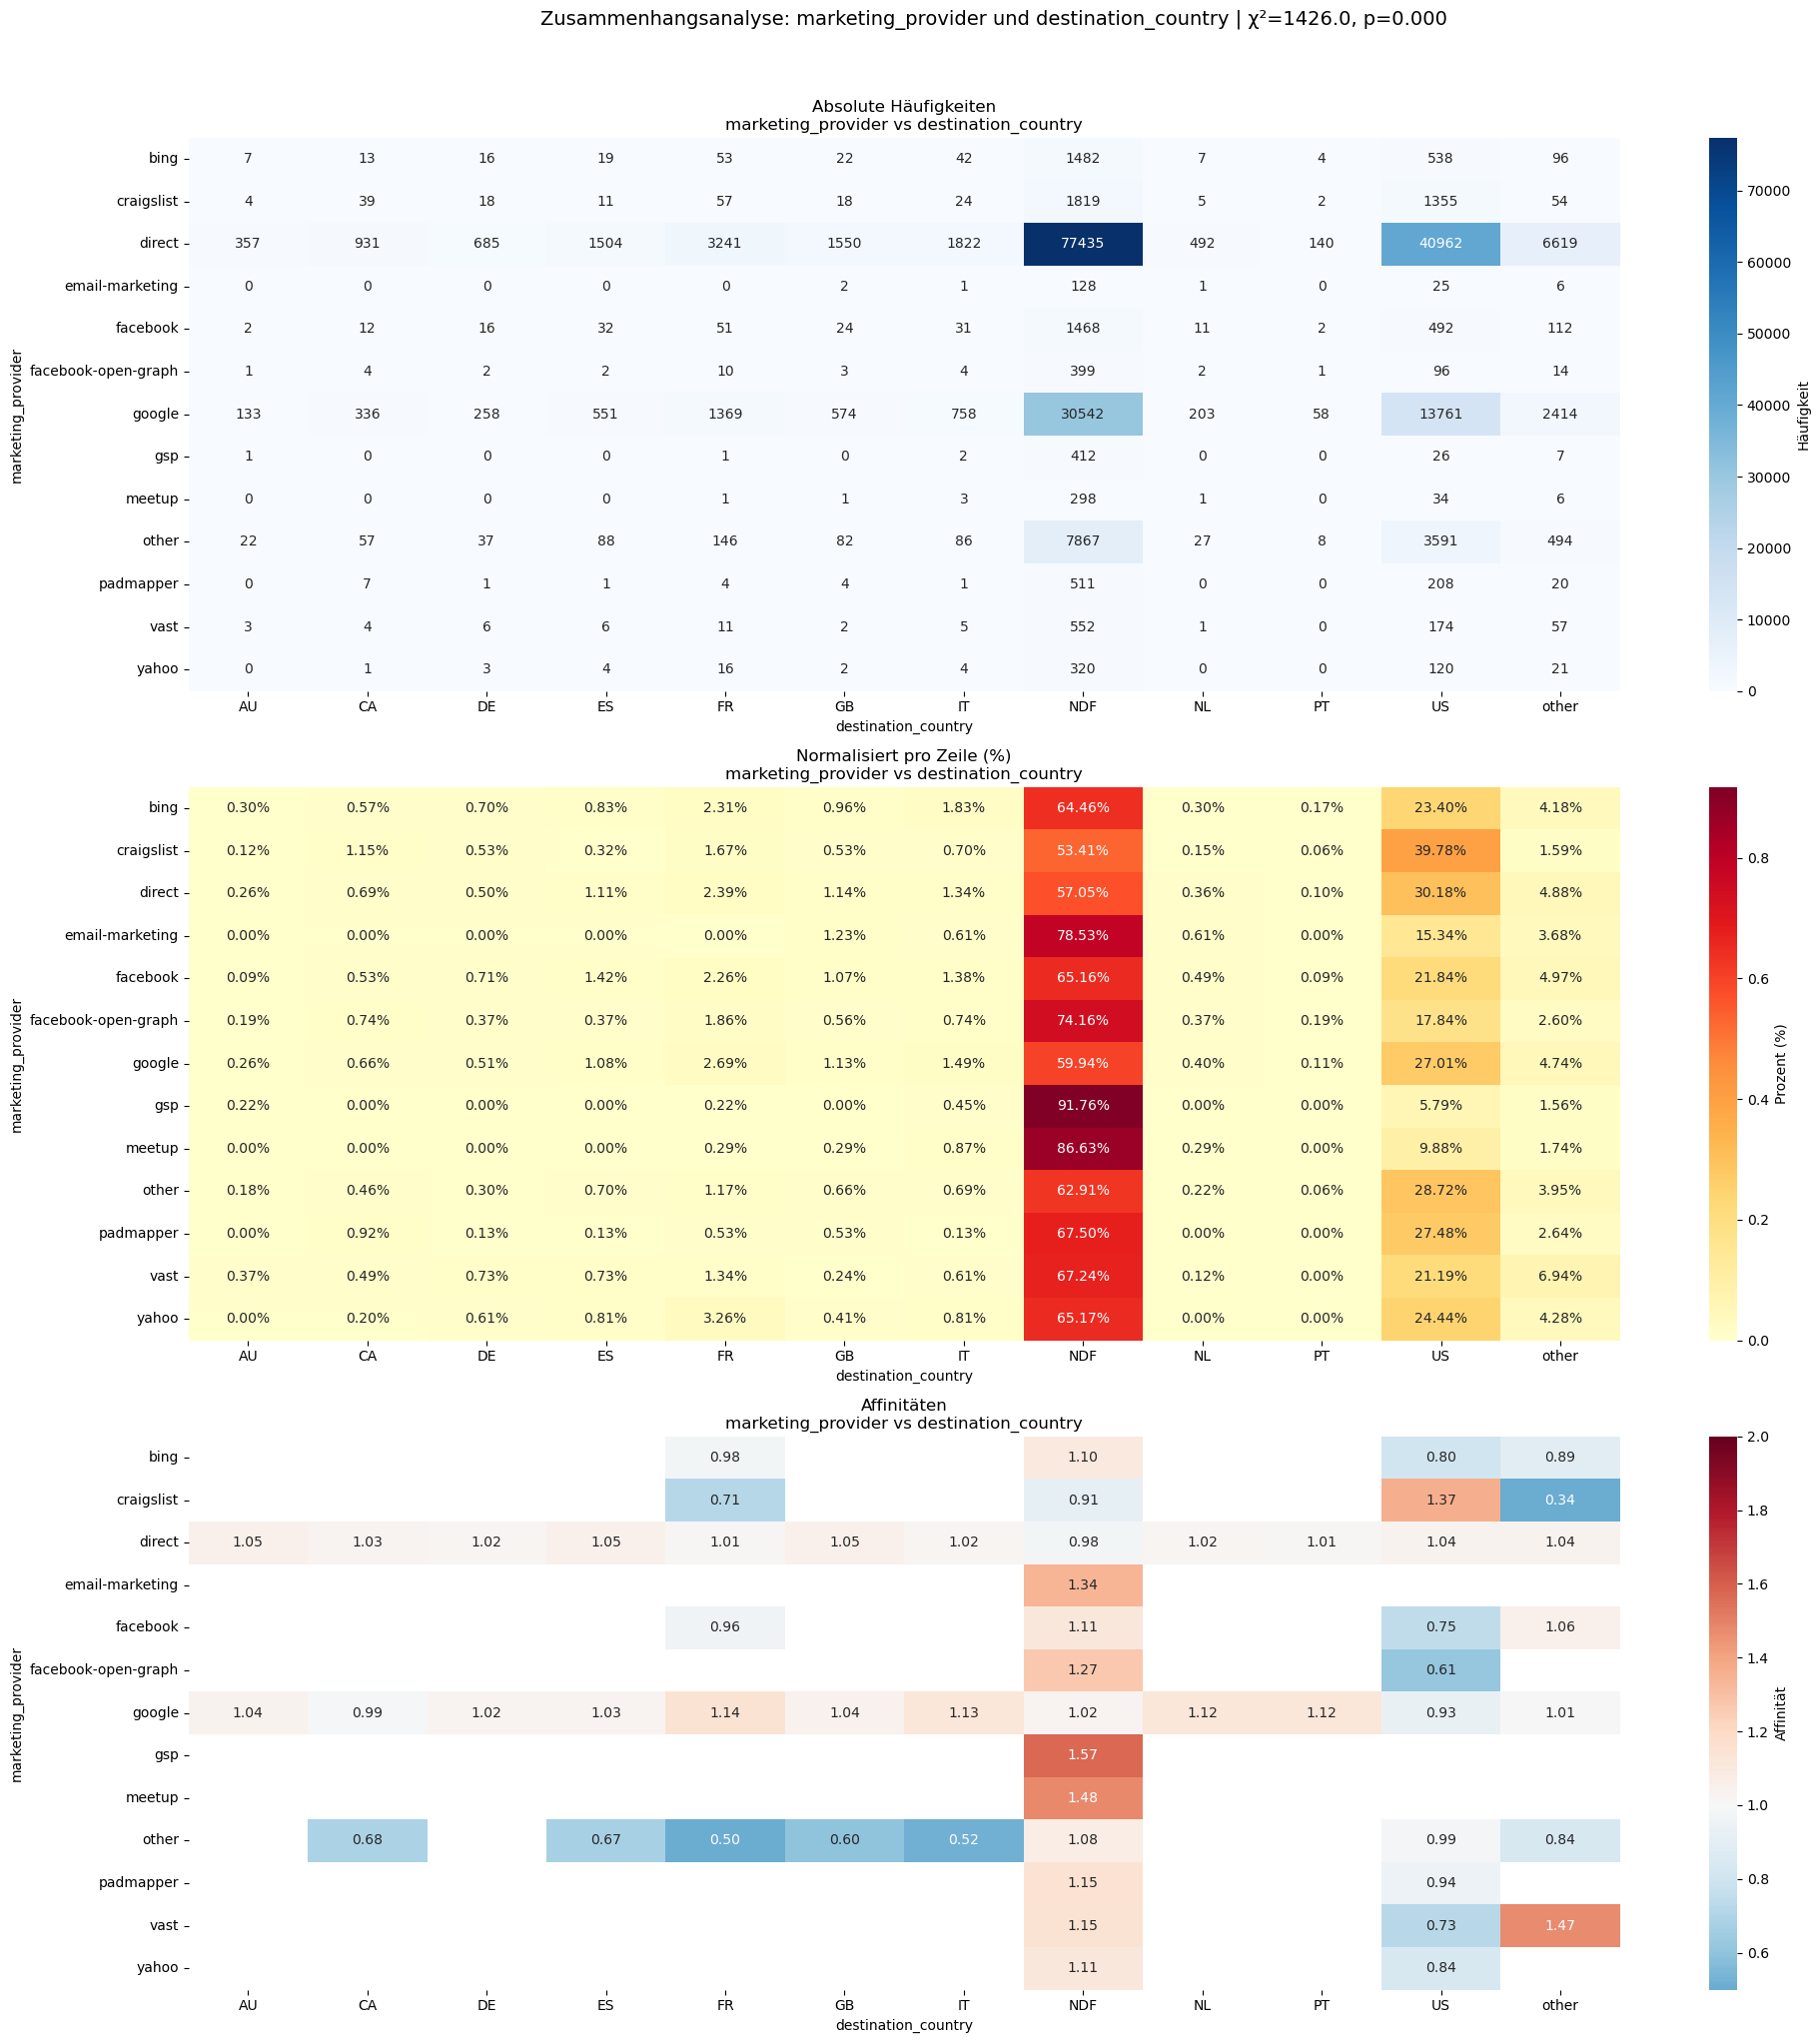


5. Stärkste Assoziationen:
    bing: NDF (64.46%)
    craigslist: NDF (53.41%)
    direct: NDF (57.05%)
    email-marketing: NDF (78.53%)
    facebook: NDF (65.16%)
    facebook-open-graph: NDF (74.16%)
    google: NDF (59.94%)
    gsp: NDF (91.76%)
    meetup: NDF (86.63%)
    other: NDF (62.91%)
    padmapper: NDF (67.50%)
    vast: NDF (67.24%)
    yahoo: NDF (65.17%)

------------------------------------------------------------------------------------------------------------------------------------------------------


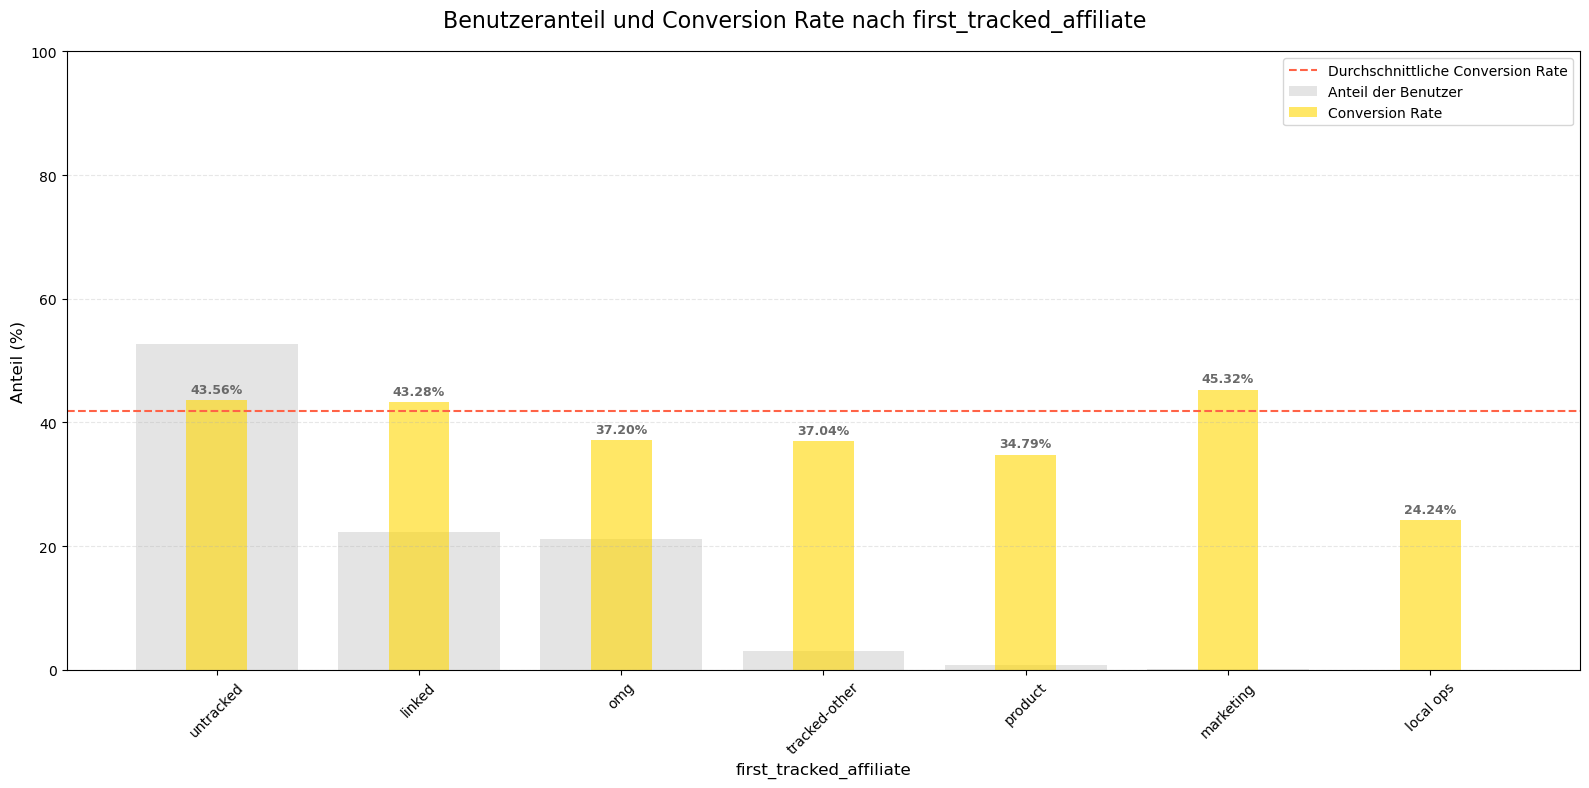

Korrelationsanalyse: first_tracked_affiliate vs destination_country

1. Datenüberblick:
   first_tracked_affiliate: 7 eindeutige Werte
   destination_country: 12 eindeutige Werte
   Gesamtbeobachtungen: 210721

2. Pearsons Chi-Quadrat-Test:
   χ² = 868.71
   p-Wert = 0.000
   Freiheitsgrade = 66

3. Interpretation:
   Sehr hohe Signifikanz nachgewiesen (p < 0.01)

4. Visualisierung:


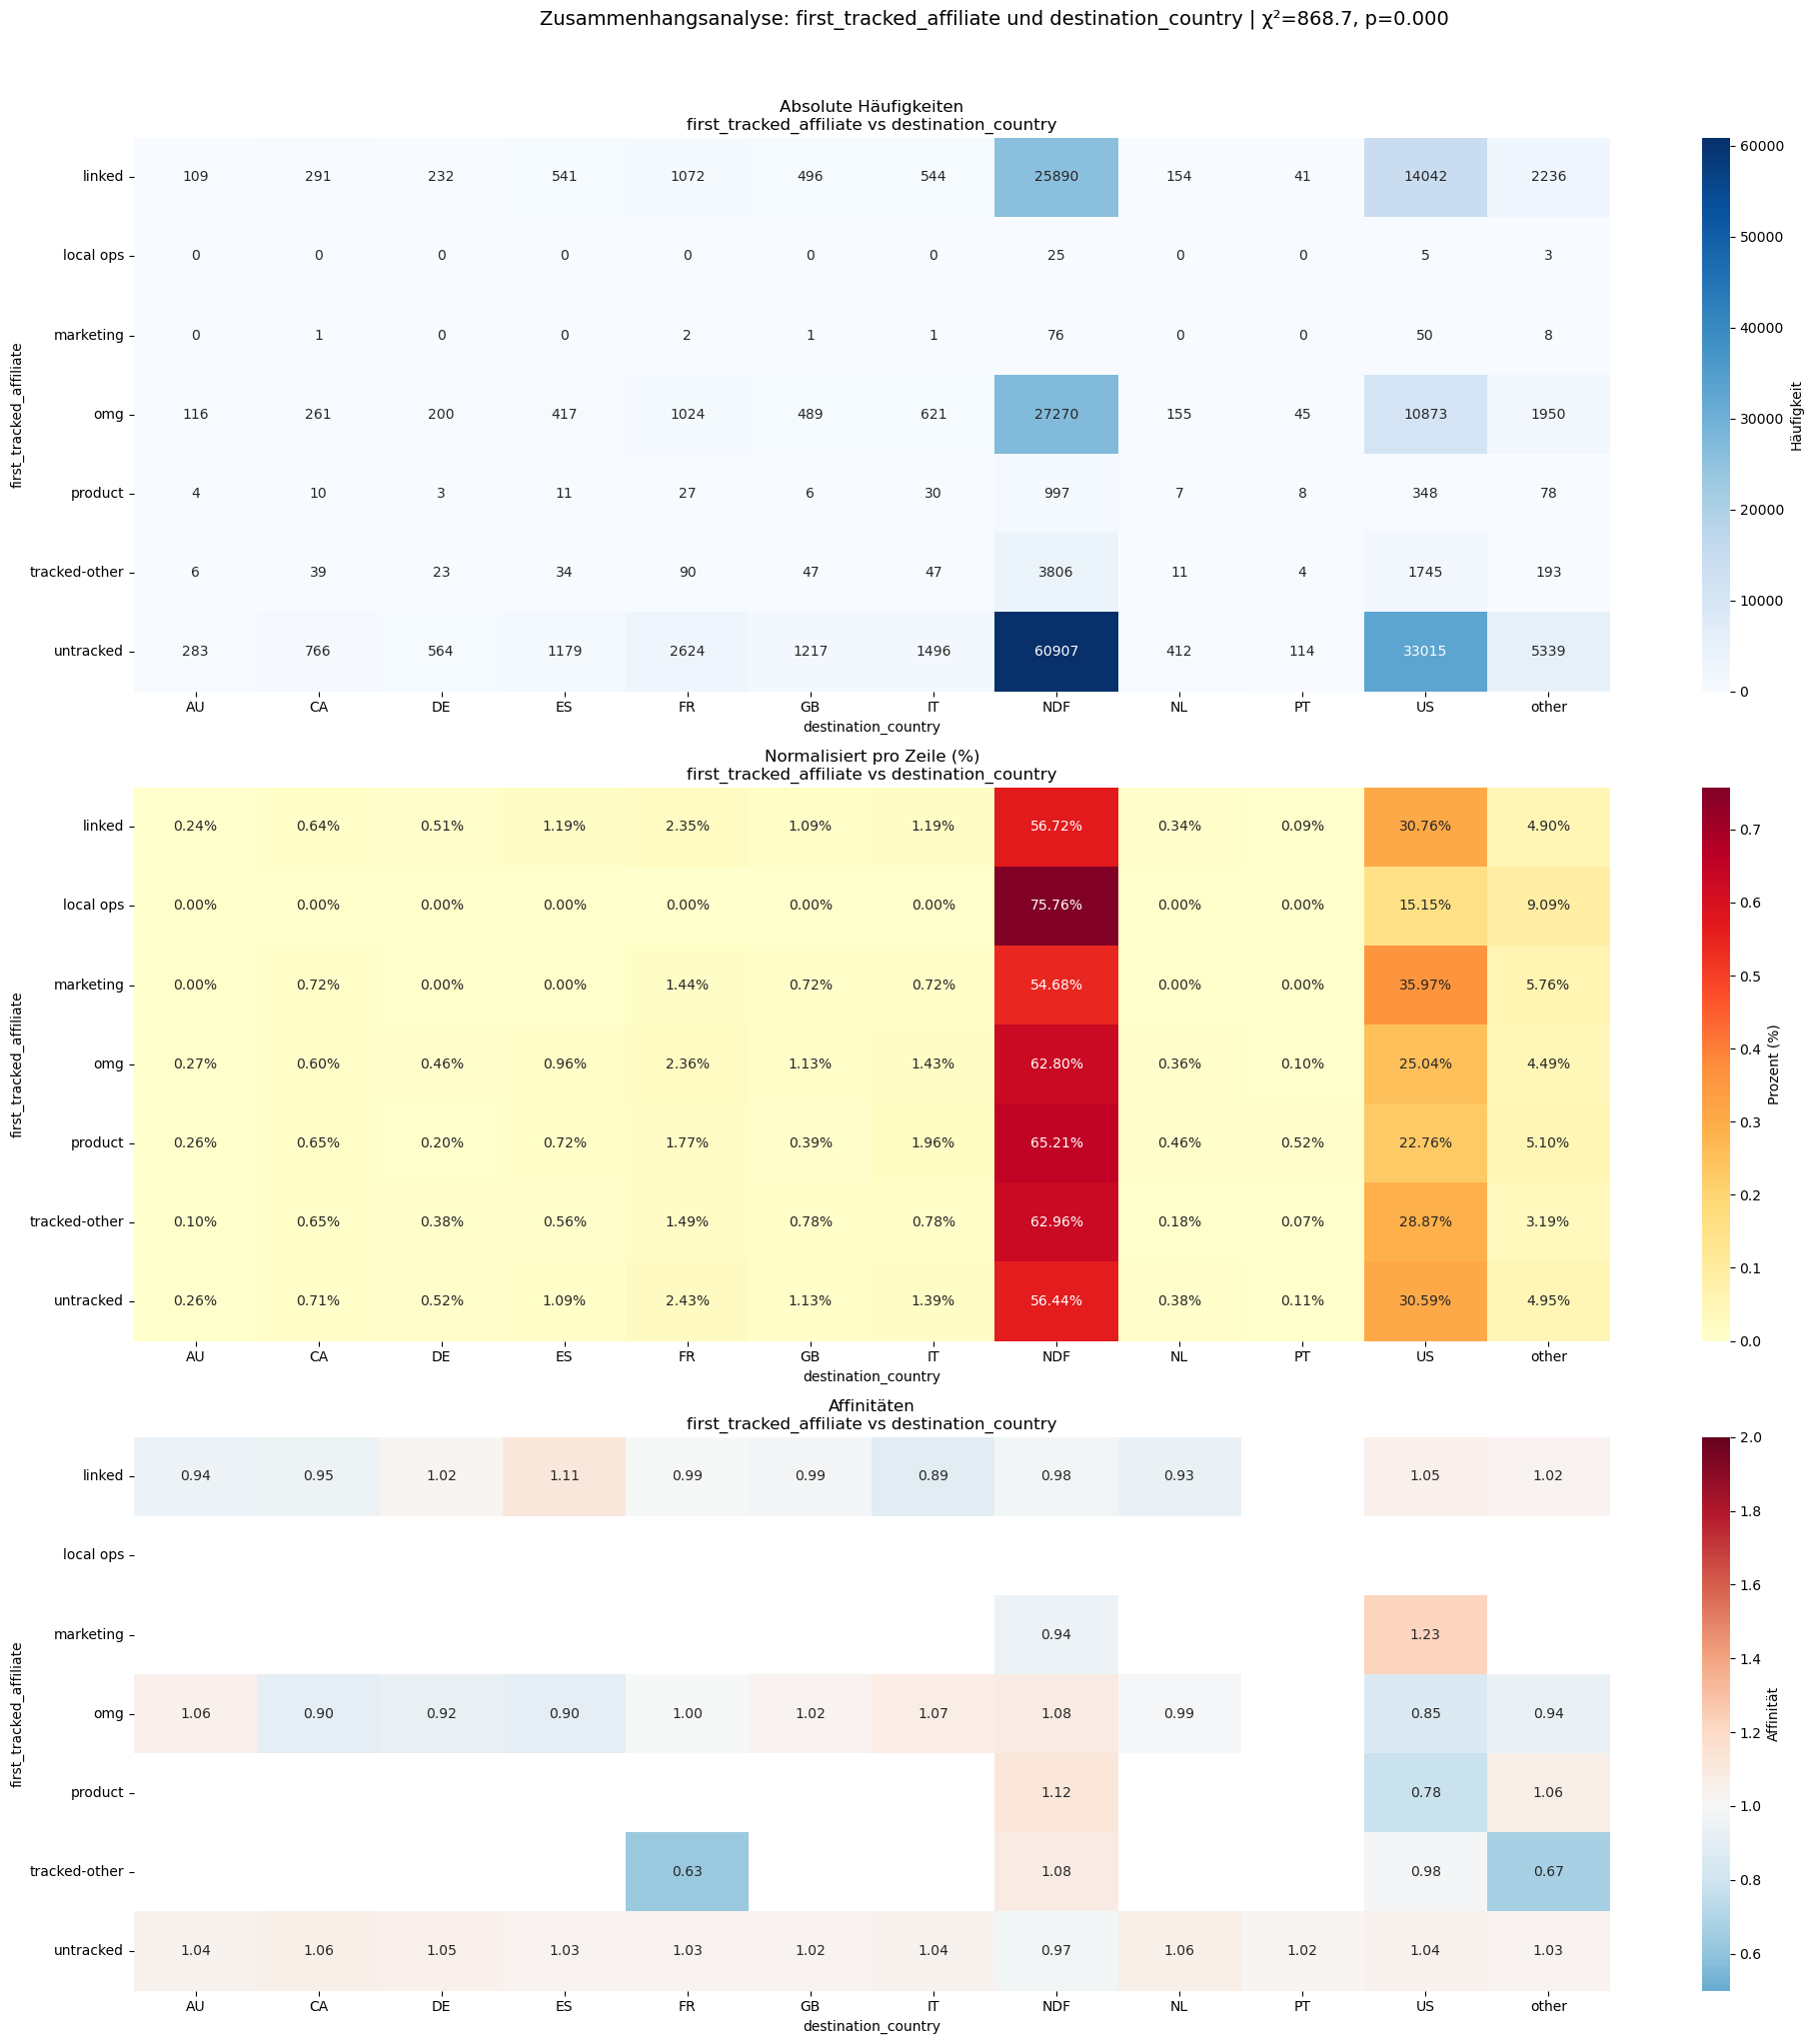


5. Stärkste Assoziationen:
    linked: NDF (56.72%)
    local ops: NDF (75.76%)
    marketing: NDF (54.68%)
    omg: NDF (62.80%)
    product: NDF (65.21%)
    tracked-other: NDF (62.96%)
    untracked: NDF (56.44%)

------------------------------------------------------------------------------------------------------------------------------------------------------


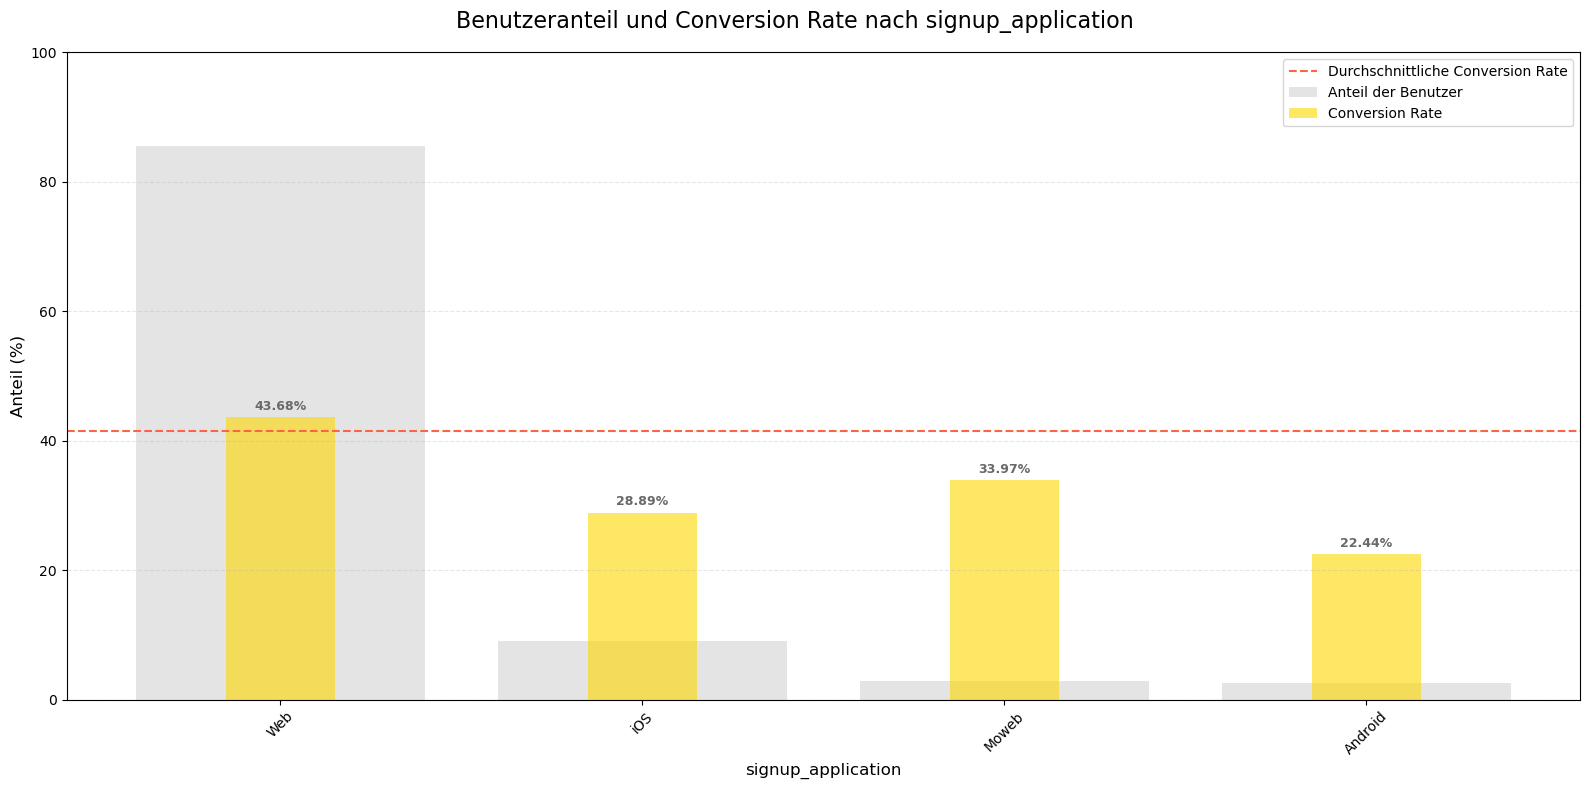

Korrelationsanalyse: signup_application vs destination_country

1. Datenüberblick:
   signup_application: 4 eindeutige Werte
   destination_country: 12 eindeutige Werte
   Gesamtbeobachtungen: 210721

2. Pearsons Chi-Quadrat-Test:
   χ² = 2754.08
   p-Wert = 0.000
   Freiheitsgrade = 33

3. Interpretation:
   Sehr hohe Signifikanz nachgewiesen (p < 0.01)

4. Visualisierung:


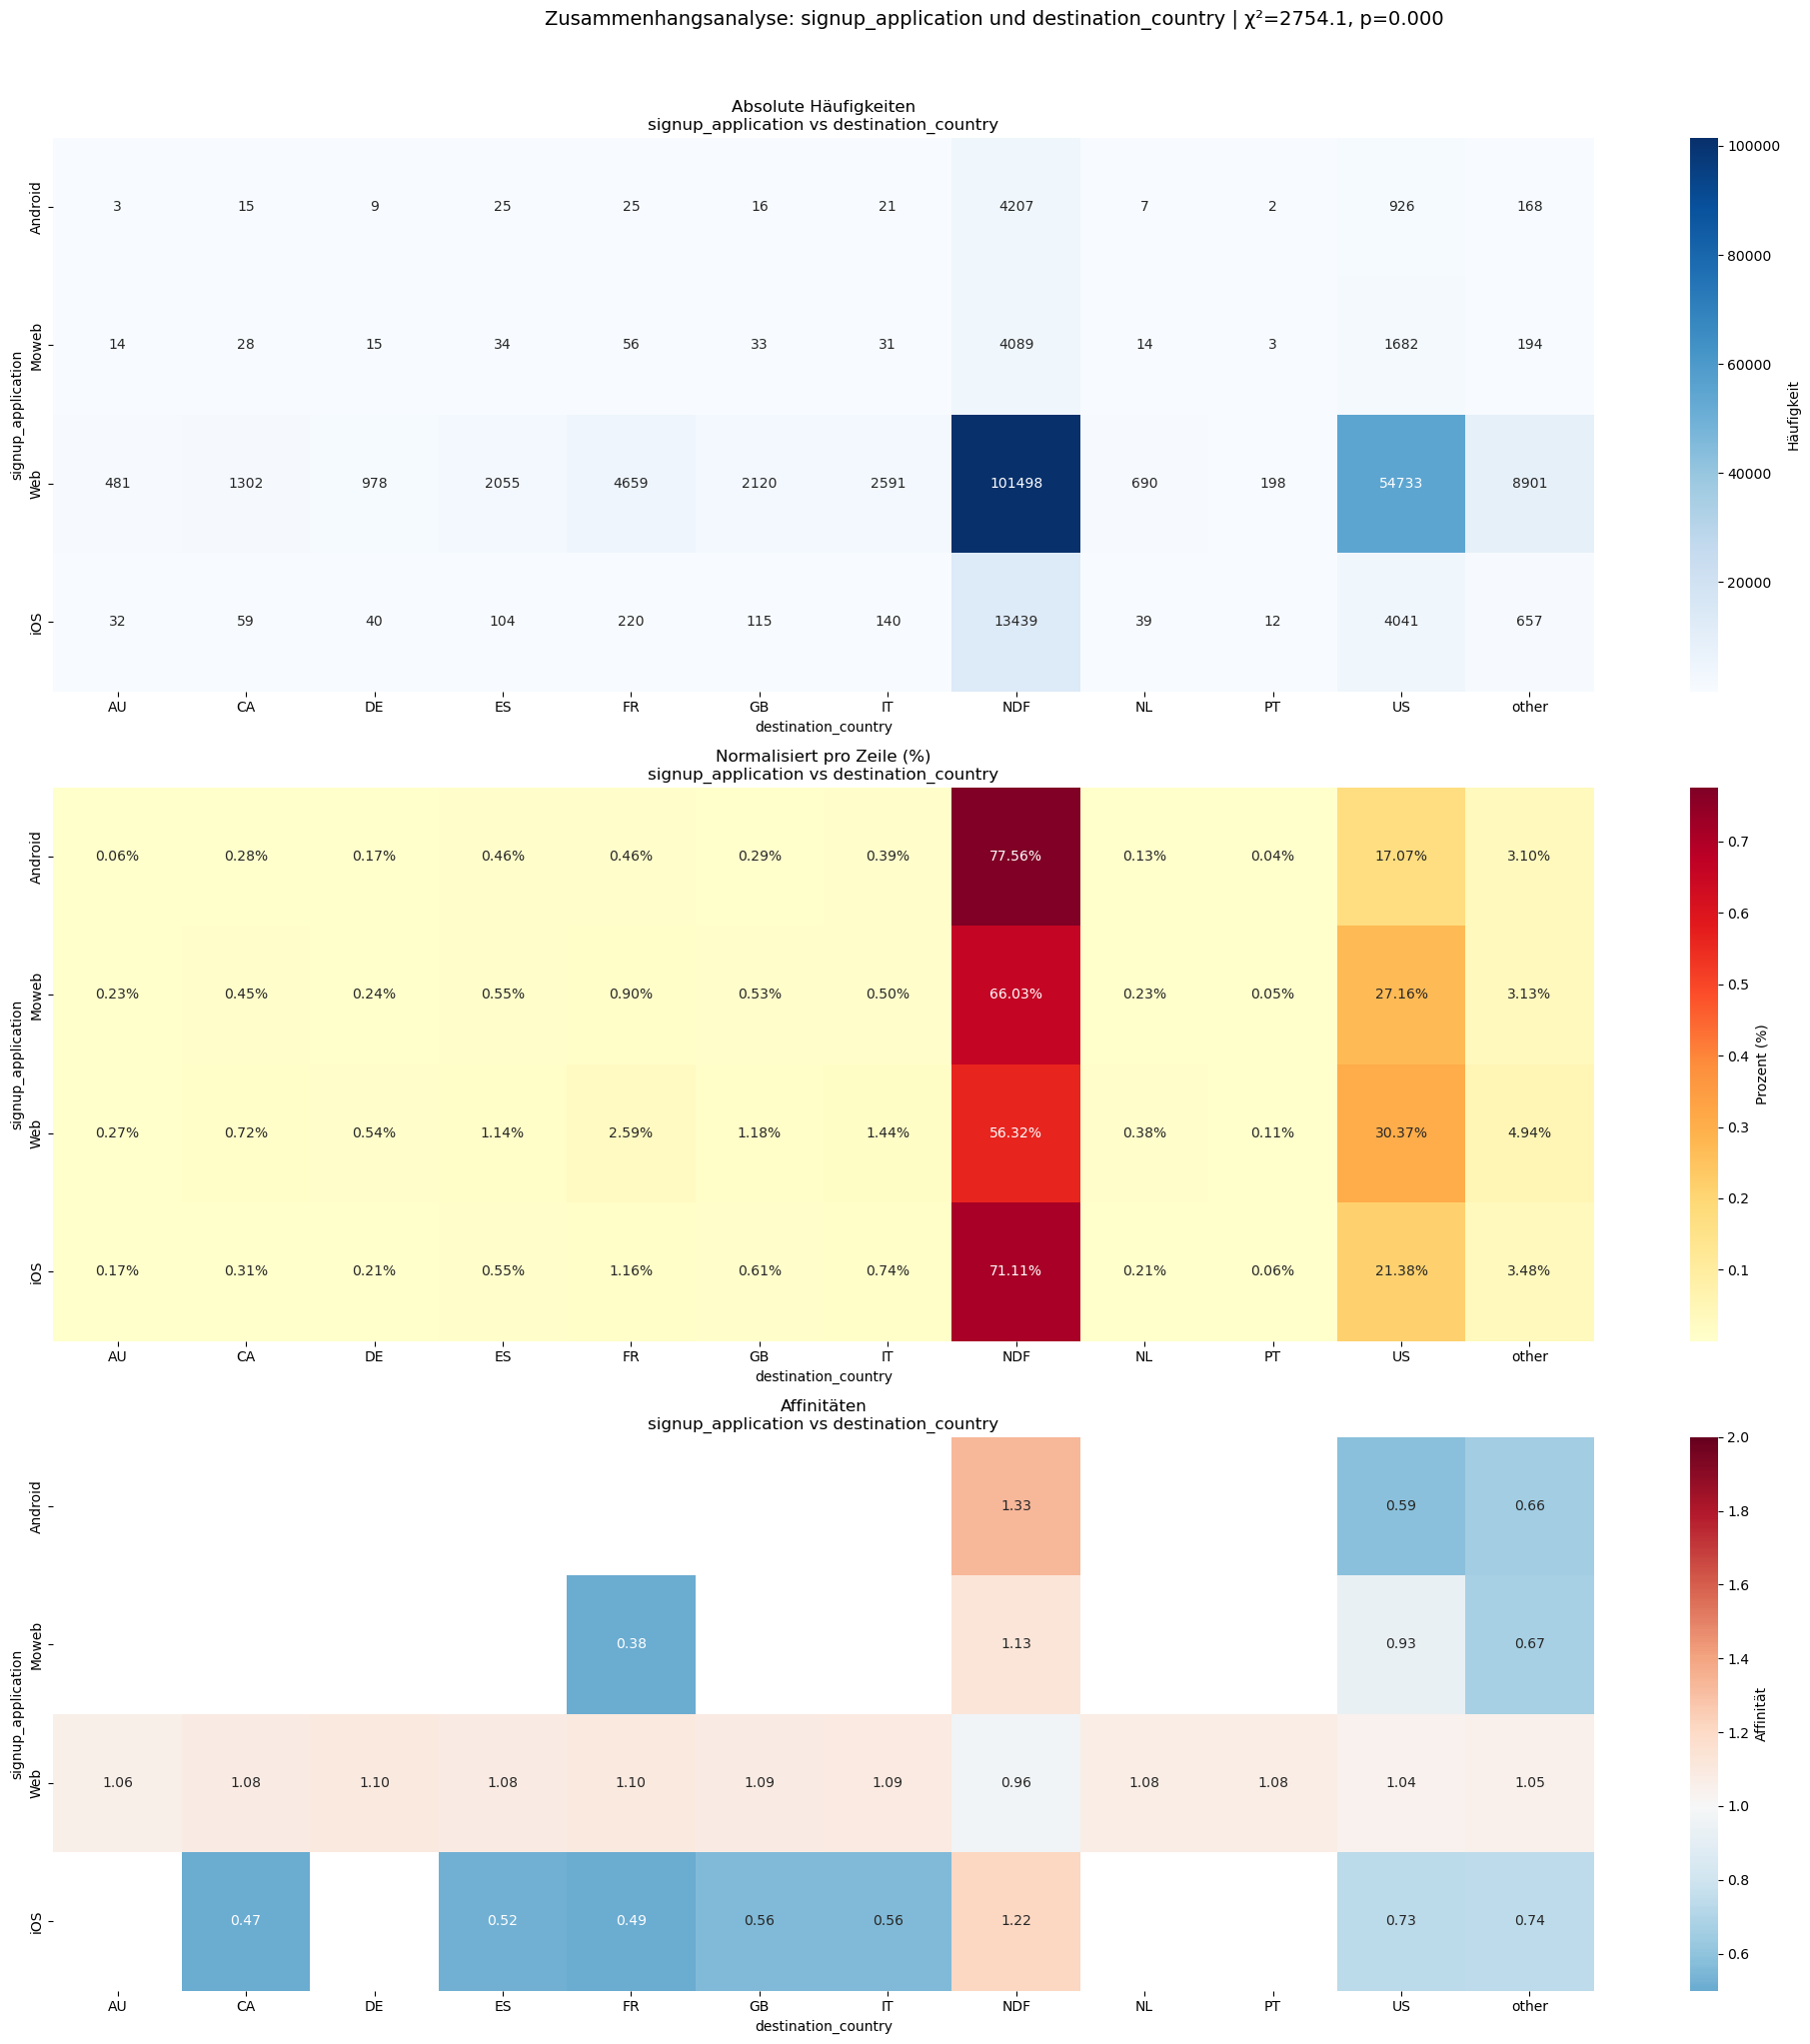


5. Stärkste Assoziationen:
    Android: NDF (77.56%)
    Moweb: NDF (66.03%)
    Web: NDF (56.32%)
    iOS: NDF (71.11%)

------------------------------------------------------------------------------------------------------------------------------------------------------


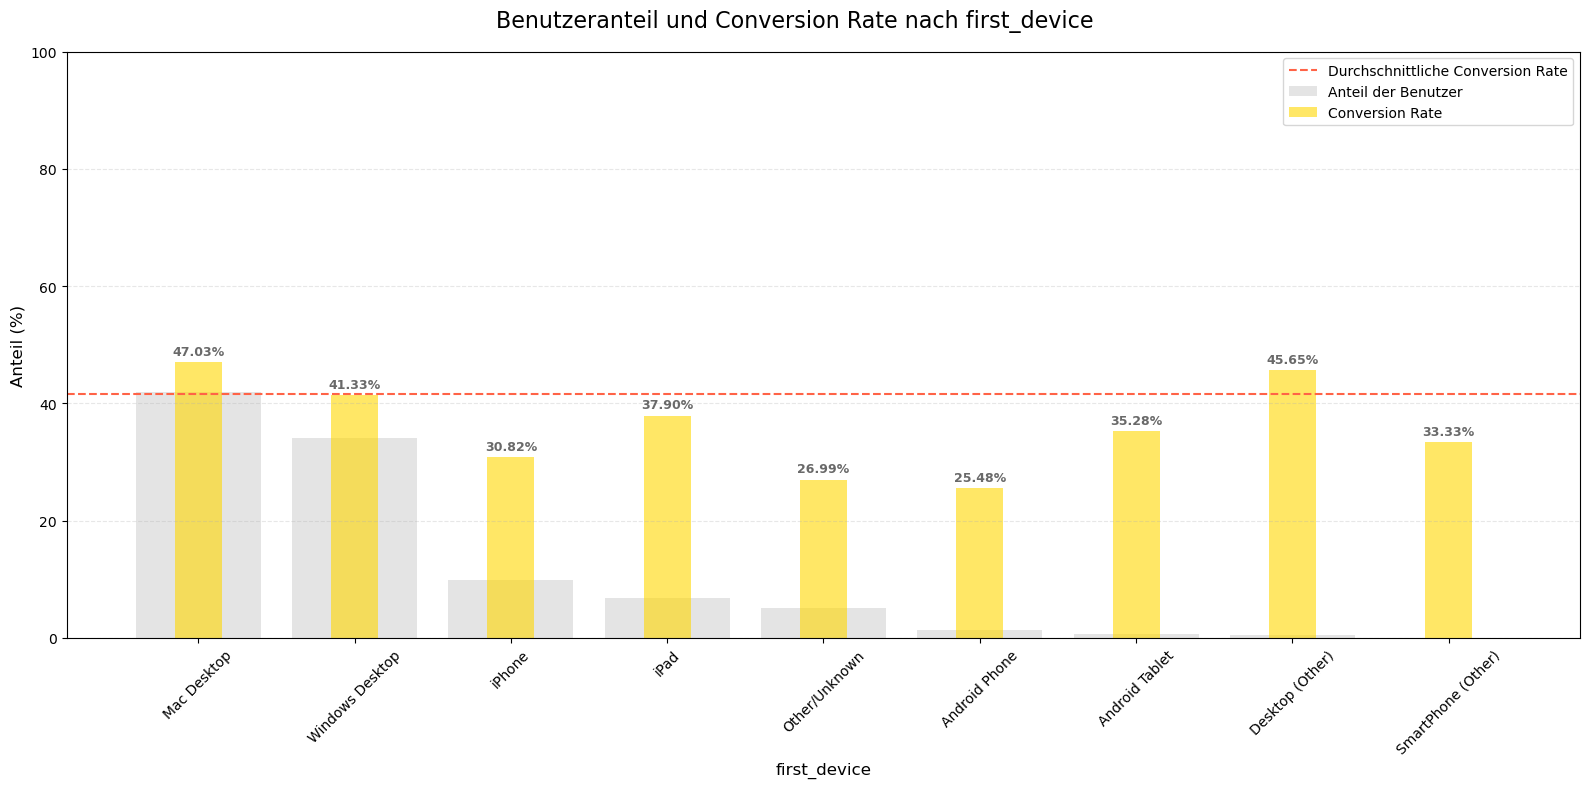

Korrelationsanalyse: first_device vs destination_country

1. Datenüberblick:
   first_device: 9 eindeutige Werte
   destination_country: 12 eindeutige Werte
   Gesamtbeobachtungen: 210721

2. Pearsons Chi-Quadrat-Test:
   χ² = 3761.05
   p-Wert = 0.000
   Freiheitsgrade = 88

3. Interpretation:
   Sehr hohe Signifikanz nachgewiesen (p < 0.01)

4. Visualisierung:


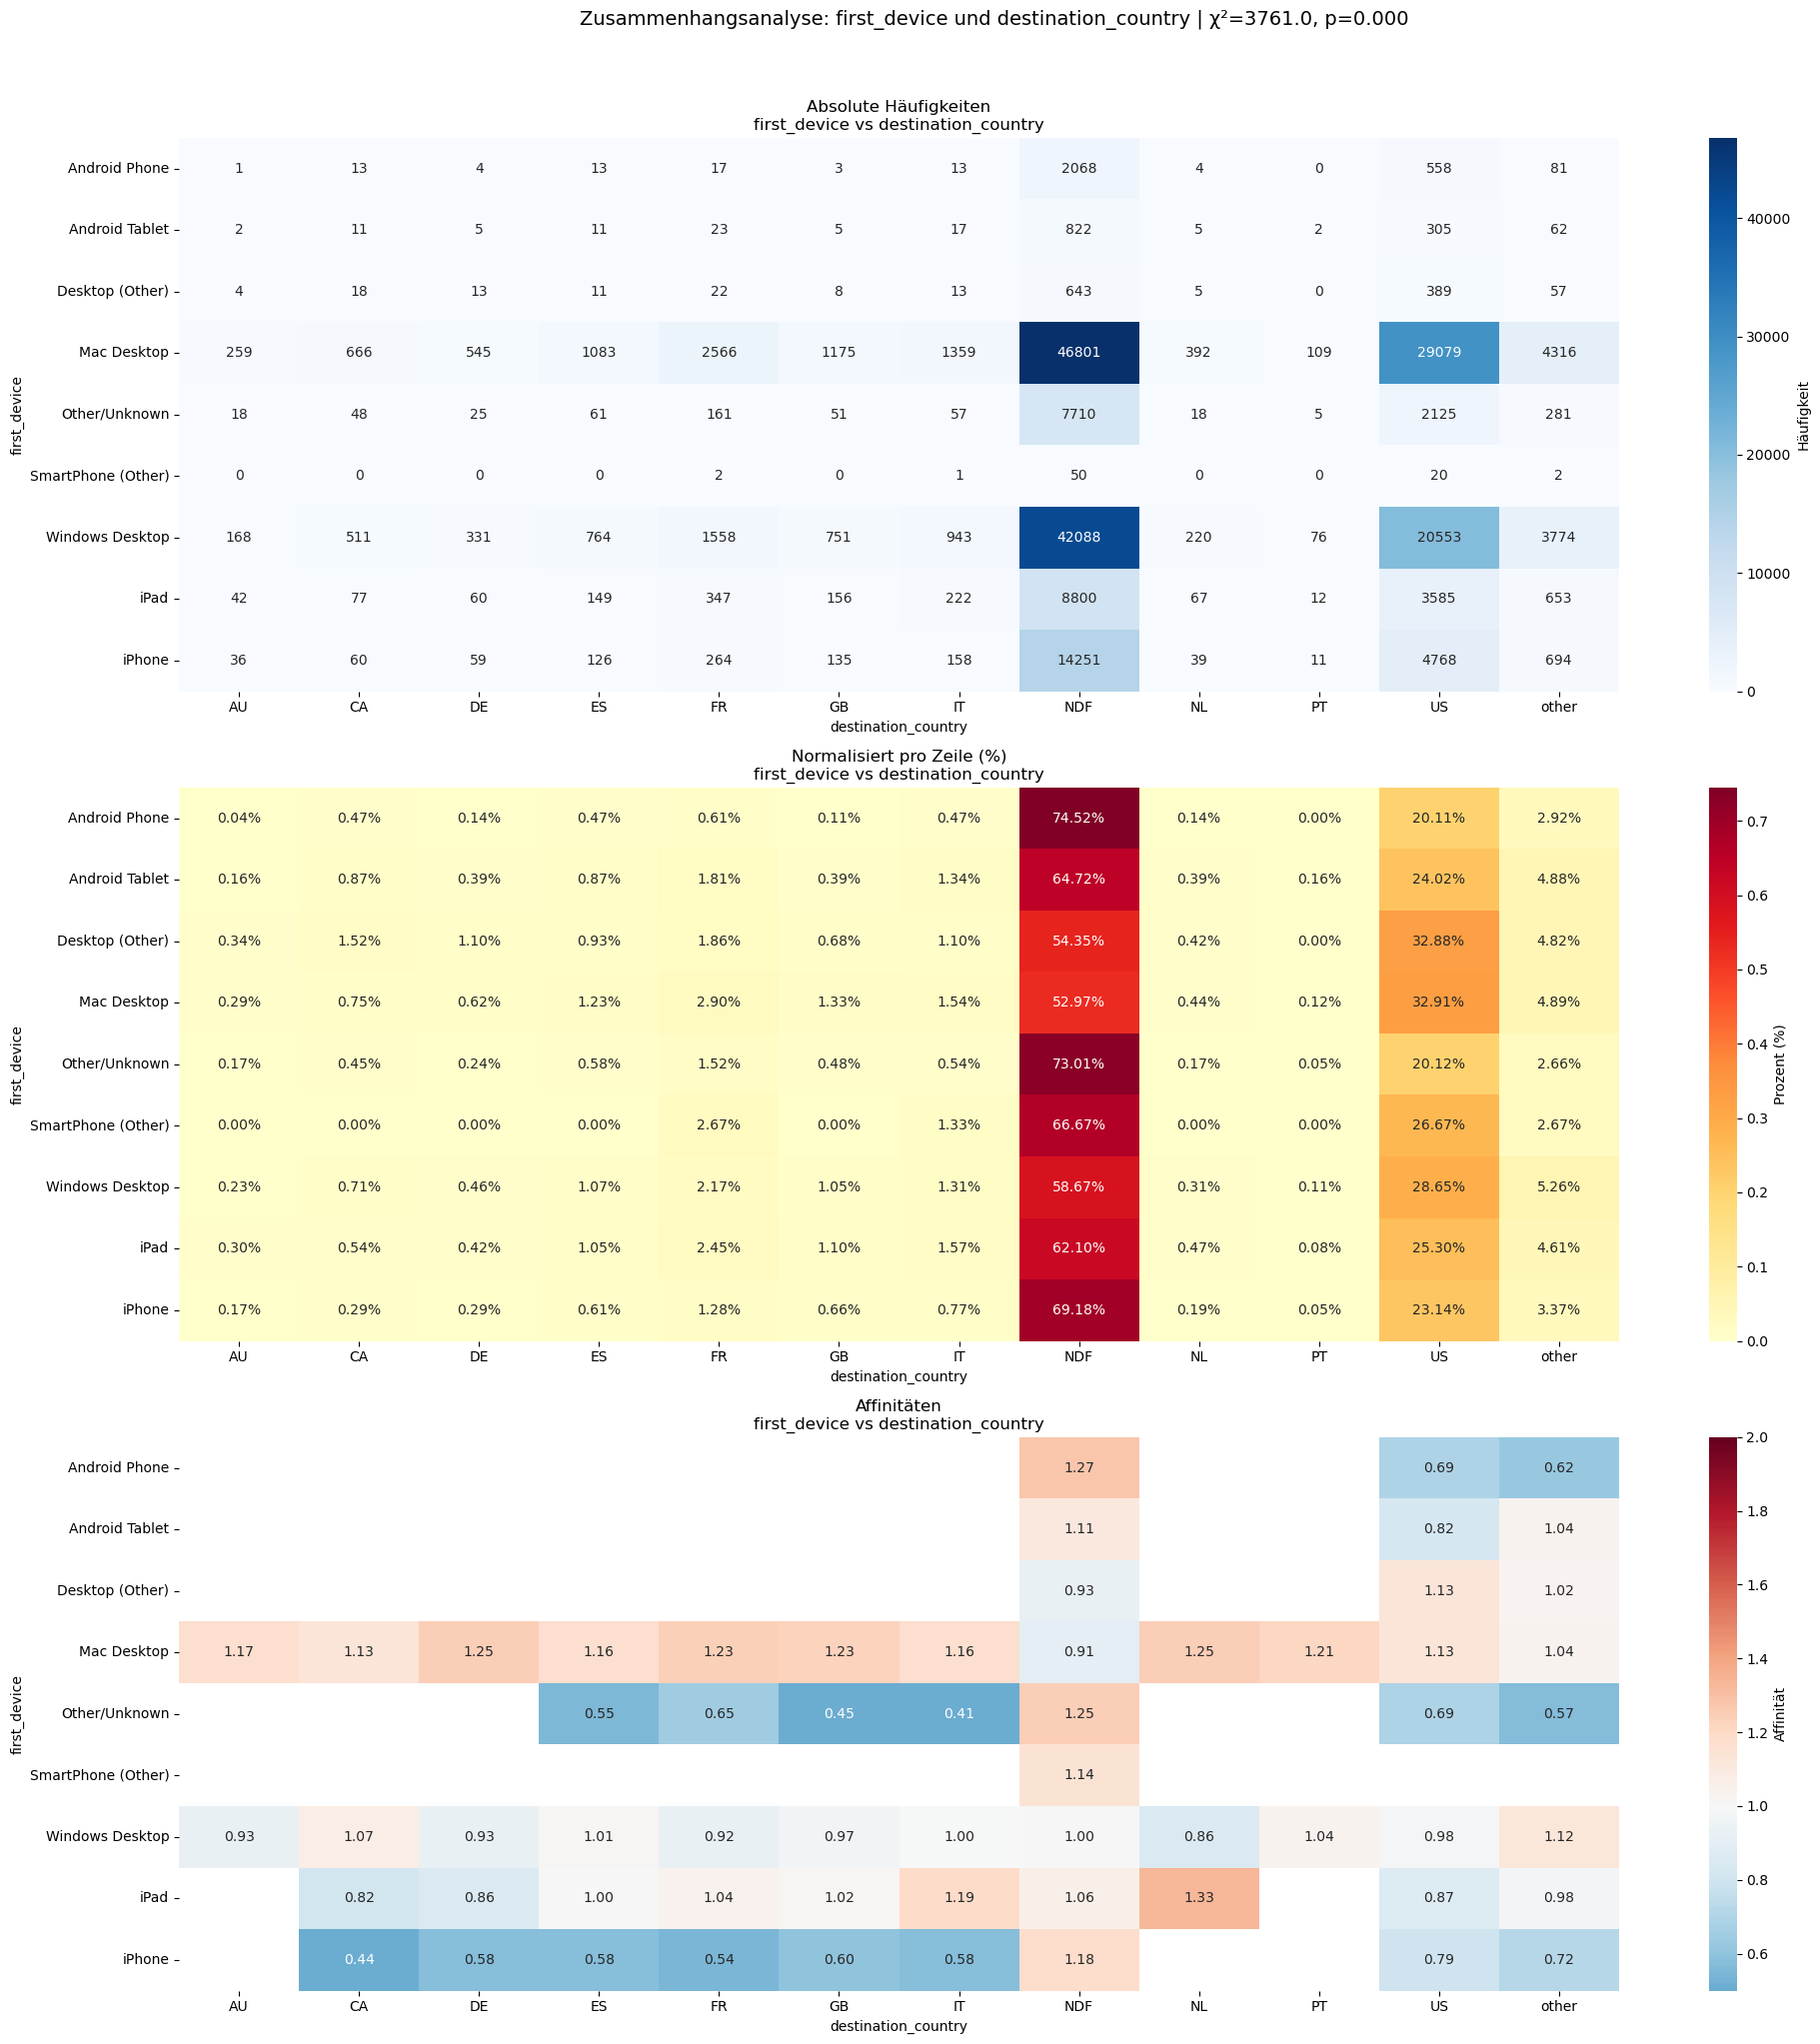


5. Stärkste Assoziationen:
    Android Phone: NDF (74.52%)
    Android Tablet: NDF (64.72%)
    Desktop (Other): NDF (54.35%)
    Mac Desktop: NDF (52.97%)
    Other/Unknown: NDF (73.01%)
    SmartPhone (Other): NDF (66.67%)
    Windows Desktop: NDF (58.67%)
    iPad: NDF (62.10%)
    iPhone: NDF (69.18%)

------------------------------------------------------------------------------------------------------------------------------------------------------


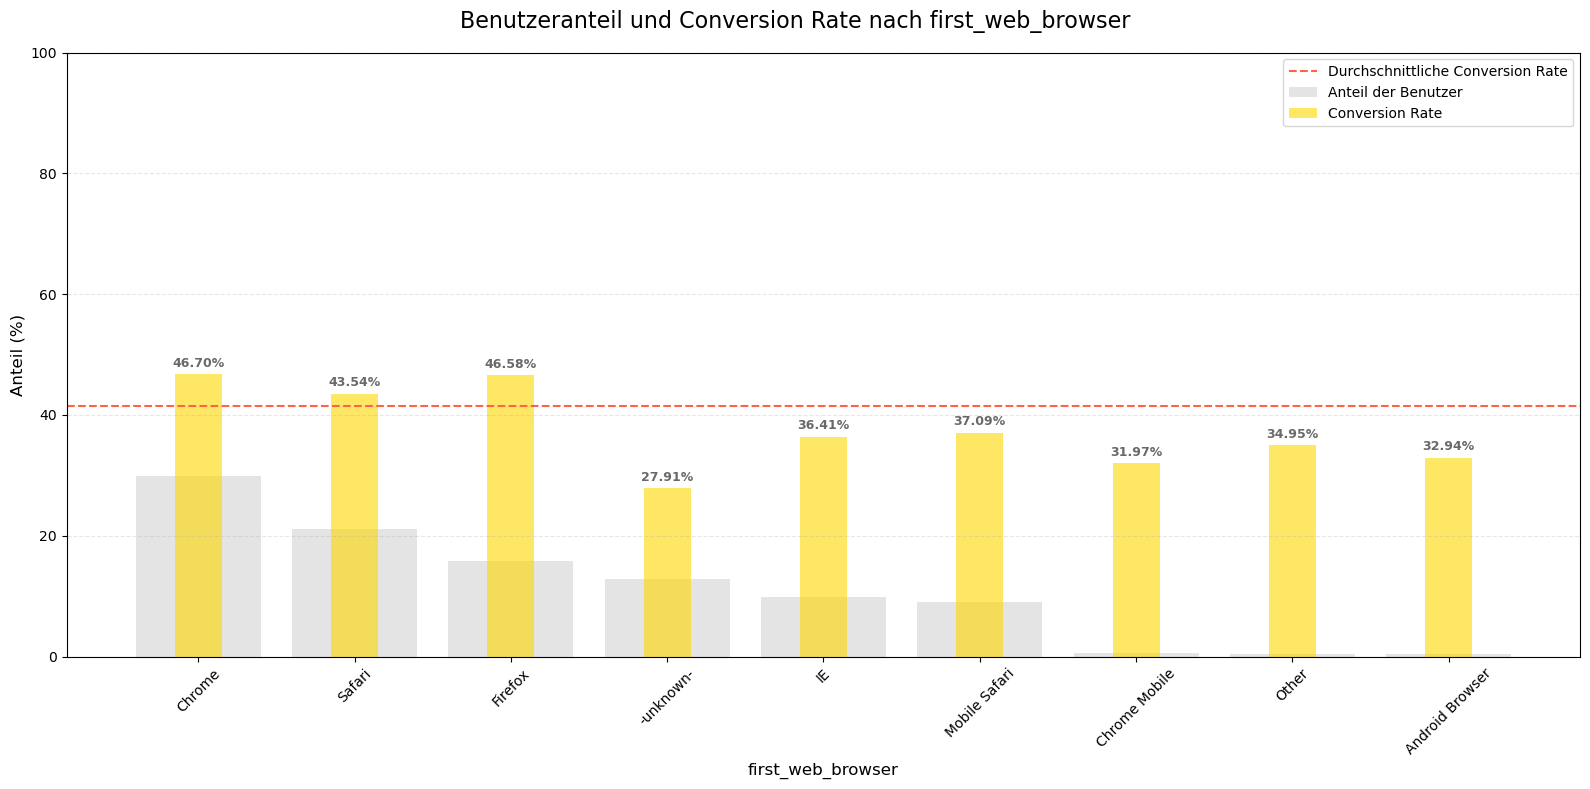

Korrelationsanalyse: first_web_browser vs destination_country

1. Datenüberblick:
   first_web_browser: 9 eindeutige Werte
   destination_country: 12 eindeutige Werte
   Gesamtbeobachtungen: 210721

2. Pearsons Chi-Quadrat-Test:
   χ² = 3912.96
   p-Wert = 0.000
   Freiheitsgrade = 88

3. Interpretation:
   Sehr hohe Signifikanz nachgewiesen (p < 0.01)

4. Visualisierung:


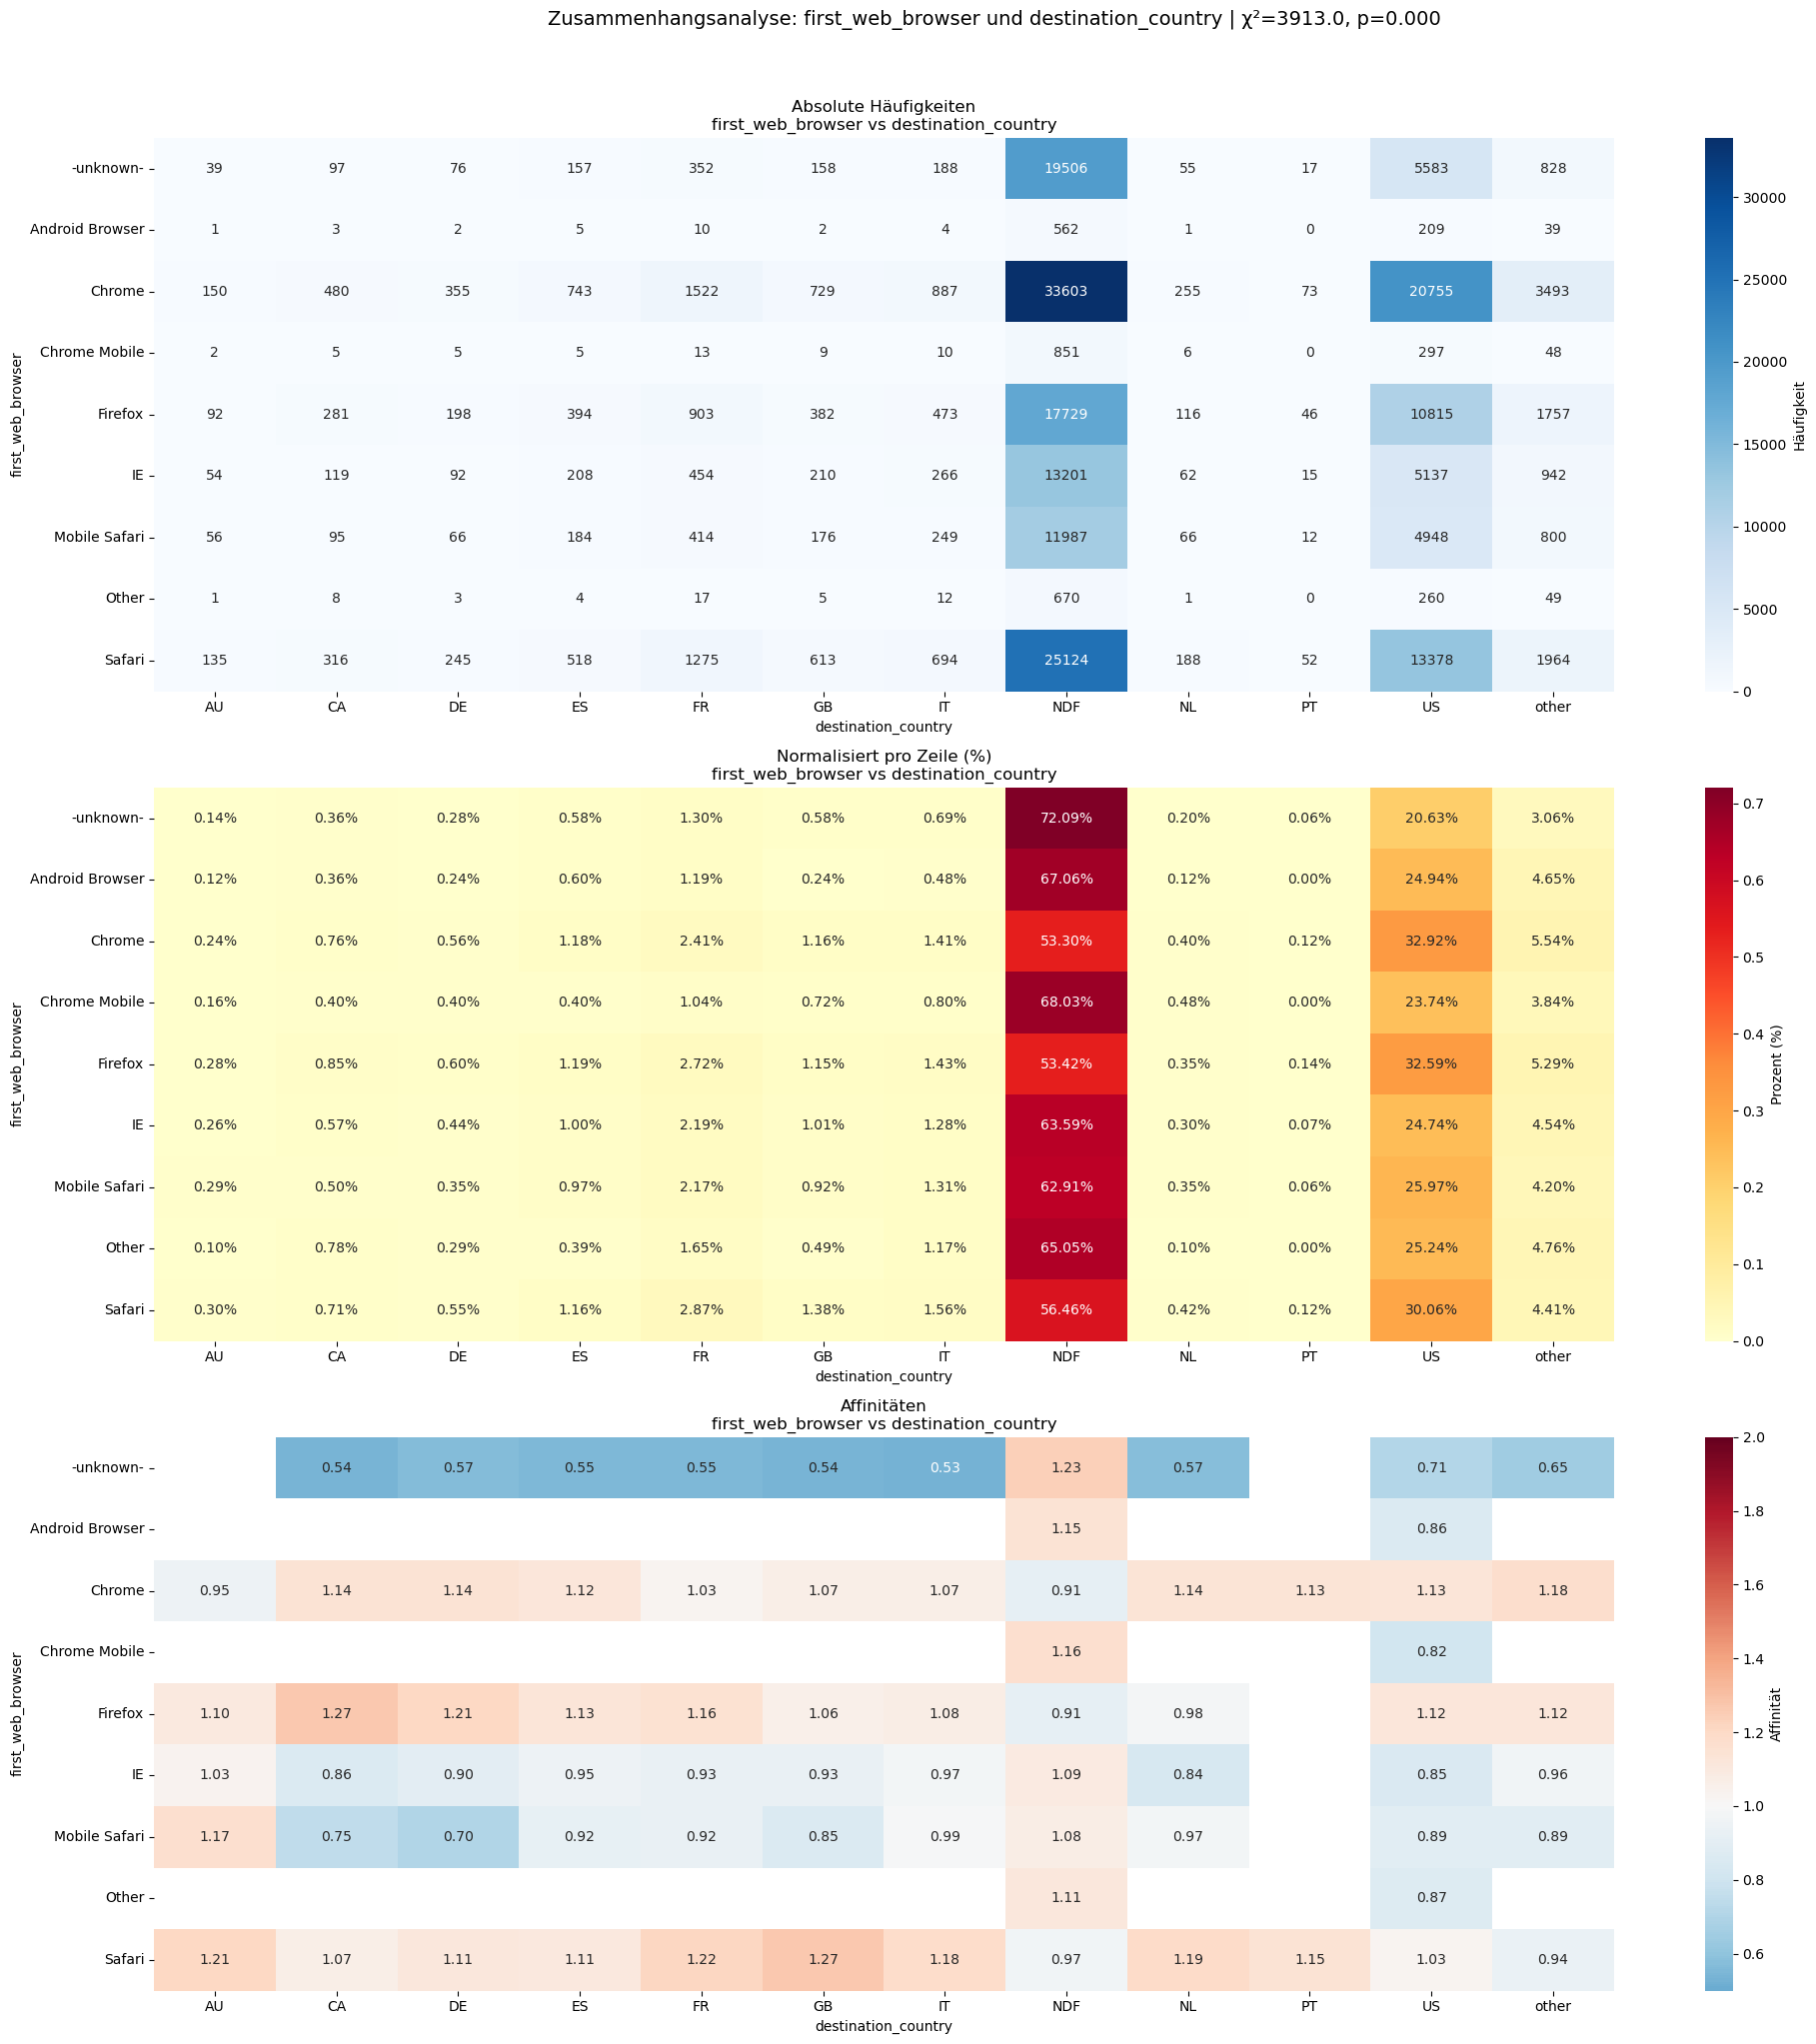


5. Stärkste Assoziationen:
    -unknown-: NDF (72.09%)
    Android Browser: NDF (67.06%)
    Chrome: NDF (53.30%)
    Chrome Mobile: NDF (68.03%)
    Firefox: NDF (53.42%)
    IE: NDF (63.59%)
    Mobile Safari: NDF (62.91%)
    Other: NDF (65.05%)
    Safari: NDF (56.46%)

------------------------------------------------------------------------------------------------------------------------------------------------------


In [14]:
categorical_cols = ['signup_platform', 'marketing_channel', 'marketing_provider', 'first_tracked_affiliate', 'signup_application', 'first_device', 'first_web_browser']
for col in categorical_cols:
    f.plot_share_vs_conversion(df_user, col)
    f.categorical_correlation_analysis(df_user, col, 'destination_country', min_sample=50)
    print('-' * 150)

# 3. Zusammenfassung und Ausblick

#### Tipps für die Marketingabteilung:

Bei der Festlegung der Reihenfolge, in der Reiseziele für verschiedene Nutzergruppen angezeigt werden (z. B. in den Suchergebnissen oder auf der Startseite), sollten folgende Präferenzen berücksichtigt werden:

1. Der Anteil der Inlandsreisen steigt (). Auch der Anteil der Reisen in seltene Länder steigt (20 % im März 2011 und 40 % im Juni 2014).
2. Bei Nutzern im Alter von 26 bis 37 Jahren sind Inlandsreisen am beliebtesten. Da solche Reisen den größten Teil aller Buchungen ausmachen, sollte für Nutzer dieser Altersgruppe die größte Auswahl an solchen Reisen an erster Stelle angezeigt werden.
3. Frauen im Alter von 30 bis 37 Jahren sowie über 62 Jahren erkunden gerne ungewöhnliche Reiseziele (`destination_country`=`other`).
4. Männer unter 37 Jahren bevorzugen Südeuropa (Spanien, Italien und Frankreich).
5. Annahmen, die auf einer geringeren Datenmenge basieren: Männer im Vorrenten- und Rentenalter buchen gerne Reisen nach Großbritannien und Frankreich, während Frauen unter 25 Jahren gerne nach Spanien reisen. Bei Frauen zwischen 30 und 41 ist Kanada besonders beliebt.
6. Besonders hervorzuheben ist das Potenzial von Reisen nach Frankreich für die Altersgruppe der 50- bis 53-Jährigen. Eine Darstellung auf der Startseite der Website könnte die ungewöhnlich niedrige Konversionsrate für diese Nutzer erhöhen.
7. Die niedrigen Konversionswerte für alle mobilen Geräte deuten darauf hin, dass die mobile Website und die mobile App komplett überarbeitet werden müssen.
8. Bei `marketing_channel`=`seo` ist der Anteil der Nutzer relativ gering (4,05 %), die Konversionsrate jedoch hoch (45,6 %). Dies deutet darauf hin, dass Investitionen in SEO vielversprechend sind, damit die Website in den Suchergebnissen weiter oben angezeigt wird.
9. Das Gleiche gilt für `marketing_provider`=`craigslist`: Der Anteil der Nutzer beträgt 1,62 %, die Conversion-Rate 46,59 %.